/tableofcontents

## NOTE: For the new material pertaining to the third assignment, please head to the section "New Model 1"

# Executive Summary


This Prjoect documents a progression from a binary image classification model for smiling detection to a more complex system integrating generative modeling. Initially, the project used a dataset of 208 facial images, preprocessing them for logistic regression and convolutional neural networks (CNNs), achieving a modest 83% accuracy. Recognizing the dataset's limitations, the second phase expanded the scope with an external dataset of 14,000 images and advanced methods like Conditional GANs (cGANs) for generating smiling images from non-smiling ones.

A data augmentation strategy was implemented to address class imbalance, using TensorFlow's ImageDataGenerator to expand the dataset while maintaining image quality. Generative and discriminative models, including a ResNet-based generator and discriminator, were trained to enhance both image generation and classification. The training loop incorporated cycle-consistency and identity loss, which ensured realistic transformations between domains.

The project shows advancements in facial expression analysis by blending detection and generation tasks, using deep learning architectures, and addressing challenges like dataset bias and computational constraints. The iterative approach demonstrates a significant improvement in model performance and scalability, setting the stage for further explorations in generative adversarial methods for facial expression synthesis.

It is important to note however, that the computational resource constraint had us restrict the number of Epochs and Batches.


# Section 1: Introduction

## Background

In Project 1, I developed a machine learning pipeline to classify images as "smiling" or "non-smiling." Using a dataset of 208 facial images, I preprocessed the data by detecting faces, converting them to grayscale, and resizing them to 64x64 pixels. The classification task was approached with Logistic Regression and a Convolutional Neural Network (CNN). Logistic Regression, combined with Principal Component Analysis (PCA) for dimensionality reduction, achieved 83% accuracy but exhibited overfitting on the raw dataset. The CNN matched this performance, leveraging its ability to extract high-level features from raw image data, though PCA integration negatively impacted its results. These findings underscored the importance of model choice and feature representation in image classification tasks.

For Project 2, I expanded upon this work by using a larger external dataset of nearly 14,000 images and incorporating generative adversarial networks (GANs) for generating smiling images from non-smiling ones. Moving beyond binary classification, the focus shifted to exploring the transformation of facial expressions through generative techniques, specifically using a ResNet-based generator-discriminator architecture. Additionally, I revisited smile detection with transfer learning by fine-tuning pre-trained models such as ResNet to achieve improved performance on the larger dataset. The generative and discriminative models were trained for up to 10 epochs, allowing for initial exploration of the models’ capabilities while balancing computational efficiency. This project emphasizes the intersection of detection and generation, broadening the scope of facial expression analysis.

## Exploratory Question

"**Is it feasible to develop a machine learning model that can generate realistic smiling images from non-smiling ones?**"




## Data Collection

For the second phase of this project, I recognized the limitations of the dataset used in the first assignment, which consisted of 208 curated images from personal photoshoots. While the original dataset was balanced and diverse in terms of demographics, its size constrained the ability to train advanced machine learning models effectively. The models and techniques implemented in this project typically require a significantly larger dataset to capture complex patterns and improve generalization.

To address this limitation, we supplemented our initial dataset with an external [dataset](https://github.com/hromi/SMILEsmileD). This dataset provides a substantial number of labeled smiling and non-smiling images, organized into positive and negative sample sets. The dataset’s increased size—nearly 14,000 images—allows us to explore more advanced generative and discriminative techniques.

The shift to using external data aligns with the technical requirements of training models that demand more extensive datasets to avoid overfitting and improve performance. Using this dataset, we now have the scale necessary to implement and evaluate methods like GANs for generating smiling images and pre-trained CNNs for improved smile detection accuracy.

## Sampling
In the previous project, I defined smiling and non-smiling images with a specific focus on distinguishing genuine smiles. A subject was considered smiling only if their mouth was open with at least some teeth visible. This approach allowed the model to differentiate genuine smiles from other expressions involving visible teeth, preventing overfitting to the simplistic rule of "visible teeth = smiling," thereby improving its accuracy in real-world scenarios.

For this assignment, the dataset we are using includes a broader variety of smiling images, encompassing both smiles with teeth and closed-mouth smiles. This expanded definition of smiles introduces additional diversity, which challenged our models to recognize different types of smiles while maintaining the ability to distinguish them from non-smiling expressions. This shift broadens the scope of the project and allows our models to generalize across varied real-world examples of smiling faces.

# Section 2: Data Processing and Feature Engineering

## Data Processing

We faced a  challenge of dataset class imbalance. Initially, our dataset comprised 9,476 non-smiling images and only 3,690 smiling images, which could have introduced significant bias in model training. To address this, we implemented an image augmentation strategy using TensorFlow's ImageDataGenerator. Our approach focused on generating additional smiling images while preserving the original dataset's fundamental characteristics.

The augmentation process involved transformations like rotation (±30 degrees), horizontal and vertical shifts (±15%), shear transformation (25% variation), zoom scaling (±25%), brightness adjustment (80-120% of original intensity), and horizontal flipping. These transformations were applied systematically to create diverse and perceptually realistic images without introducing artificial distortions. All original images were preserved, and augmentations were applied iteratively to ensure the final dataset reached near-parity with the count of non-smiling images.

The implementation included error handling to address potential file processing issues. The script also calculated the required number of augmentations per image based on the target dataset size, and an additional mechanism was included to generate supplementary augmentations if the initial round did not meet the target. The final result was a balanced dataset containing 9,476 smiling images, achieved through a combination of original and augmented images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input
from glob import glob
import time

In [ ]:
# Paths to the folders
smile_folder = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/positives7'
augmented_smile_folder = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/Augmented Smiles'
os.makedirs(augmented_smile_folder, exist_ok=True)

# Function to safely list image files
def list_image_files(folder):
    return [f for f in os.listdir(folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
            and not f.startswith('.')]
'''
# Augmentation setup
datagen = ImageDataGenerator(
    rotation_range=30,      # Increased rotation
    width_shift_range=0.15, # Increased shift
    height_shift_range=0.15,
    shear_range=0.25,       # Increased shear
    zoom_range=0.25,        # Increased zoom
    horizontal_flip=True,
    vertical_flip=False,    # Added vertical flip option
    brightness_range=[0.8, 1.2],  # Added brightness variation
    fill_mode='nearest'
)

# Count existing images and calculate augmentation needed
smile_images = list_image_files(smile_folder)
num_existing_images = len(smile_images)
target_num_images = 9476  # Number of non-smiling images

# Calculate augmentations
def calculate_augmentations(total_existing, target_total):
    augmentations_per_image = max(1, (target_total // total_existing) - 1)
    return augmentations_per_image

augmentations_per_image = calculate_augmentations(num_existing_images, target_num_images)

print(f"Existing images: {num_existing_images}")
print(f"Augmentations per image: {augmentations_per_image}")
print(f"Total target images: {target_num_images}")

# Copy original images first
for img_name in tqdm(smile_images, desc="Copying original images"):
    try:
        src_path = os.path.join(smile_folder, img_name)
        dst_path = os.path.join(augmented_smile_folder, img_name)

        # Ensure source file exists and is a file
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)
        else:
            print(f"Skipping {img_name}: not a valid file")
    except Exception as e:
        print(f"Error copying {img_name}: {e}")

# Augmentation loop
augment_count = 0
total_images_needed = target_num_images - num_existing_images

for img_name in tqdm(smile_images, desc="Augmenting images"):
    try:
        img_path = os.path.join(smile_folder, img_name)

        # Skip if file doesn't exist
        if not os.path.isfile(img_path):
            continue

        img = load_img(img_path, target_size=(64, 64))  # Resize images to 64x64
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)  # Add batch dimension

        # Generate augmented versions of the current image
        augmentations_created = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_smile_folder,
                                   save_prefix=f'aug_{os.path.splitext(img_name)[0]}',
                                   save_format='jpg'):
            augmentations_created += 1
            augment_count += 1

            # Stop when we've created enough augmentations for this image
            if augmentations_created >= augmentations_per_image:
                break

        # Break the outer loop if we've reached the target number of images
        if augment_count >= total_images_needed:
            break
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

# If we still haven't reached the target, do additional random augmentations
if augment_count < total_images_needed:
    print(f"Generating additional {total_images_needed - augment_count} images")

    # Randomly select images to further augment
    while augment_count < total_images_needed:
        for img_name in smile_images:
            try:
                img_path = os.path.join(smile_folder, img_name)

                # Skip if file doesn't exist
                if not os.path.isfile(img_path):
                    continue

                img = load_img(img_path, target_size=(64, 64))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Generate one more augmented image
                for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_smile_folder,
                                           save_prefix=f'extra_aug_{os.path.splitext(img_name)[0]}',
                                           save_format='jpg'):
                    augment_count += 1
                    break

                if augment_count >= total_images_needed:
                    break

            except Exception as e:
                print(f"Error in extra augmentation for {img_name}: {e}")
'''
# Verify final count
final_images = list_image_files(augmented_smile_folder)
print(f"Total images in augmented folder: {len(final_images)}")


Total images in augmented folder: 9476


## **Image Augmentation**

Image augmentation uses geometric and intensity transformations to expand and diversify datasets. The goal is to create statistically meaningful variations of existing images that capture the inherent complexity of visual data while maintaining the essential characteristics of the original imagery.

### **Mathematical Transformation Framework**

Each augmentation technique can be understood as a mathematical mapping that transforms the original image matrix $I$ into an augmented image matrix $I'$. These transformations are fundamentally linear and affine operations that manipulate the spatial and intensity characteristics of the image.

### **Rotation Transformation**

The rotation transformation represents a 2D coordinate rotation using a rotation matrix. Mathematically, this is expressed through a two-dimensional rotation matrix:

$$R = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$$

This matrix accomplishes a coordinate transformation that rotates points about the origin, with the rotation angle $\theta$ controlling the magnitude of geometric distortion. The range $\theta \in [-30^\circ, +30^\circ]$ ensures subtle, realistic variations that mimic natural image variations.

### **Translation (Shift) Transformation**

Translation represents a simple coordinate addition, shifting image pixels by discrete horizontal and vertical offsets. This is expressed as:

$$
\left\{
\begin{array}{ll}
x' = x + \Delta x \\
y' = y + \Delta y
\end{array}
\right\}
$$



The offsets $\Delta x$ and $\Delta y$ are constrained to $[-15\%, +15\%]$ of the image dimensions, providing controlled spatial perturbations that simulate variations in object positioning.

### **Shear Transformation**

Shear transformations introduce a skew to the image coordinate system through a linear transformation matrix:

$$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} 1 & \text{shear} \\ 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}$$

The shear parameter ranges $\text{shear} \in [-0.25, +0.25]$, creating controlled geometric distortions that simulate perspective and alignment variations.

### **Scaling (Zoom) Transformation**

Scaling modifies image dimensions through a simple multiplicative coordinate transformation:

$$
\left\{
\begin{array}{ll}
x' = x \cdot s \\
y' = y \cdot s
\end{array}
\right\}
$$

With $s \in [0.75, 1.25]$, this transformation introduces variations in image size that mimic changes in object distance or camera zoom.

### **Brightness Adjustment**

Brightness modification represents a linear intensity scaling:

$$I'_{i,j} = \alpha \cdot I_{i,j}$$

Where $\alpha \in [0.8, 1.2]$ provides controlled luminance variations that simulate different lighting conditions.

### **Horizontal Flipping**

Horizontal flipping represents a coordinate reflection across the vertical axis:

$$
\left\{
\begin{array}{ll}
x' = W - x \\
y' = y
\end{array}
\right\}
$$

Applied with 50% probability, this transformation introduces symmetrical variations.

## **Probabilistic and Statistical Considerations**

The augmentation process is inherently probabilistic, which means that it introduced controlled randomness that statistically expands the effective training dataset. Each transformation acts as a mathematical operator that generates new data points while preserving the fundamental statistical properties of the original imagery.

### **Dataset Balancing Mathematics**

The augmentation strategy addresses class imbalance by systematically generating additional training samples. By calculating the required augmentations per original image and applying transformations with controlled parameters, the process creates a statistically representative and balanced dataset.

## Visualizing the Data

Below, we will now visualize and compare a sample image from the **negative (non-smiling)** dataset and the **augmented (smiling)** dataset side by side. This will ensure that both datasets are correctly loaded and that the augmentation process has not introduced any distortions or errors.

Next, we use the `get_image_details` function to extract properties of each image, such as:
1. **Shape**: The dimensions of the image.
2. **Data Type**: The type of the pixel values (e.g., `uint8`).
3. **Pixel Intensity Range**: The minimum and maximum pixel values.
4. **Mean Pixel Intensity**: The average pixel intensity across the image.

Once the images are loaded and their details are printed for verification, we visualize them using **Matplotlib**. The visualization involves two subplots:
1. The **first subplot** displays the non-smiling image from the negative folder. It is rendered in grayscale using `plt.imshow(neg_img, cmap="gray")`.axis("off")` for a cleaner display.
2. The **second subplot** displays the smiling image from the augmented folder, similarly rendered in grayscale with the title "Augmented Image."



Negative Image Details:
{'Shape': (64, 64), 'Data Type': dtype('uint8'), 'Min Pixel Value': 12, 'Max Pixel Value': 206, 'Pixel Mean': 108.861572265625}

Augmented Image Details:
{'Shape': (64, 64), 'Data Type': dtype('uint8'), 'Min Pixel Value': 0, 'Max Pixel Value': 255, 'Pixel Mean': 115.634521484375}


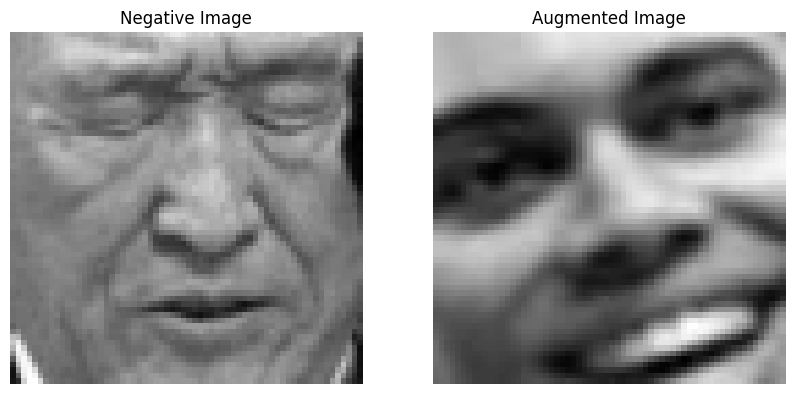

In [ ]:
# Paths to the folders
negative_folder = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/negatives7'
augmented_folder = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/Augmented Smiles'

def get_image_details(image_path):
    """
    Load and display image details.
    """
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Ensure it's loaded as grayscale
    if img is None:
        print(f"Image at {image_path} could not be loaded.")
        return None
    # Get image details
    details = {
        "Shape": img.shape,
        "Data Type": img.dtype,
        "Min Pixel Value": np.min(img),
        "Max Pixel Value": np.max(img),
        "Pixel Mean": np.mean(img),
    }
    return img, details

# Select a sample image from each folder
negative_images = list_image_files(negative_folder)
augmented_images = list_image_files(augmented_folder)

if negative_images and augmented_images:
    negative_sample = os.path.join(negative_folder, negative_images[0])
    augmented_sample = os.path.join(augmented_folder, augmented_images[0])

    # Get details for each image
    neg_img, neg_details = get_image_details(negative_sample)
    aug_img, aug_details = get_image_details(augmented_sample)

    # Display details
    print("Negative Image Details:")
    print(neg_details)
    print("\nAugmented Image Details:")
    print(aug_details)

    # Plot images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(neg_img, cmap="gray")
    plt.title("Negative Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(aug_img, cmap="gray")
    plt.title("Augmented Image")
    plt.axis("off")
    plt.show()
else:
    print("No images found in one or both folders.")


## **Preprocessing Images for Model Training**

### **Resizing Images**
We resized the images to ensure that all input images have consistent dimensions, which is essential for convolutional neural networks (CNNs) that require fixed input sizes. Inconsistent image sizes would disrupt batch processing and cause errors during training.

Resizing involves interpolating pixel values to map the original image dimensions (h, w) to the target size (64, 64). Each pixel value in the resized image is determined by interpolating its corresponding position in the original image:

$$
I'_{i,j} = \text{interpolate}(I, \frac{i}{64} \cdot h, \frac{j}{64} \cdot w)
$$


---

### **Normalization**
Normalization transforms pixel intensity values from the range \([0, 255]\) to \([-1, 1]\). This step is important for the following reasons:
1. **Numerical Stability**: Centering data around zero prevents excessively large gradients that may destabilize training and small gradients that slow convergence.
2. **Equal Feature Contribution**: It ensures all pixel values contribute equally to training, preventing features with larger magnitudes from dominating.

The transformation formula is:
$$
I'_{i,j} = \frac{I_{i,j}}{127.5} - 1
$$

- A pixel value of \(0\) maps to \(-1\) (black).
- A pixel value of \(255\) maps to \(1\) (white).
- A pixel value of \(127.5\) maps to \(0\) (neutral gray).

This mapping symmetrically centers pixel values around zero, enhancing the efficiency of weight updates during training. The improved numerical stability accelerates convergence and ensures the model's robustness.

---

### **Shuffling**
We are also shuffling the dataset to randomize the order of training samples, ensuring the model does not learn spurious patterns from the input sequence. Without shuffling, the model might overfit to correlations arising solely from the order of the data, hindering generalization.

Mathematically, shuffling ensures diverse gradient directions in stochastic gradient descent (SGD), which improves optimization:
$$
\text{Gradient diversity} \implies \text{Smoother convergence to global/local optimum.}
$$

---

### **Batching**
Batching splits the dataset into smaller subsets (batches) for processing during training to balance computational efficiency and model performance:
- **Small Batches**: More frequent updates to model weights, helping escape local minima.
- **Large Batches**: More accurate gradient approximation over the dataset, stabilizing convergence.

Batching approximates the true gradient $(\nabla J$) using a subset of data points $(B)$:
$$
\nabla J \approx \frac{1}{|B|} \sum_{i \in B} \nabla J_i
$$
Here:
- $(|B|$) is the batch size.
- $(J_i$) is the loss for a single sample $(i$).

Batching reduces computational overhead while retaining enough accuracy for effective optimization.

---

### **Prefetching**
We are also implementing prefetching to mitigate input pipeline latency by preparing the next batch of data while the current batch is being processed. This overlap between data preparation and computation ensures that hardware resources (CPU/GPU) are utilized efficiently, minimizing idle time.

From a pipeline perspective, prefetching optimizes resource utilization, making the data loading process almost invisible to the computational workflow.


Exception ignored in: <function _xla_gc_callback at 0x78fa047bda20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


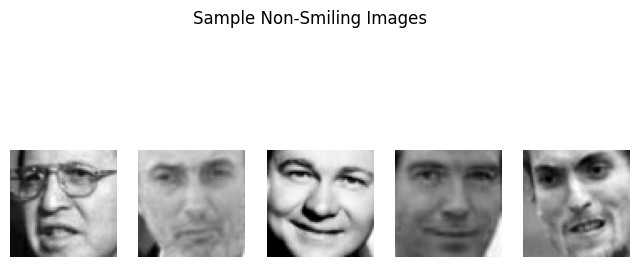

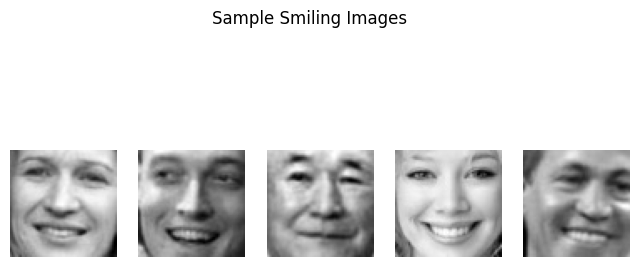

In [ ]:
# Paths to datasets
non_smiling_path = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/negatives7'  # Domain A
smiling_path = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/positives7'  # Domain B

# Constants
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 64, 64, 1
BUFFER_SIZE = 1000
BATCH_SIZE = 32


# Function to preprocess images
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Get list of file paths
non_smiling_files = glob(os.path.join(non_smiling_path, '*.jpg'))
smiling_files = glob(os.path.join(smiling_path, '*.jpg'))

# Create datasets
def create_dataset(file_paths):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Use the helper function
non_smiling_dataset = create_dataset(non_smiling_files)
smiling_dataset = create_dataset(smiling_files)


# Display sample images
def display_sample_images(dataset, title):
    plt.figure(figsize=(8, 4))
    for i, img in enumerate(dataset.take(5)):
        plt.subplot(1, 5, i + 1)
        img = (img.numpy() + 1) * 127.5  # Rescale to [0, 255]
        plt.imshow(img.astype('uint8').reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Display samples from the datasets

display_sample_images(non_smiling_dataset.unbatch(), "Sample Non-Smiling Images")

display_sample_images(smiling_dataset.unbatch(), "Sample Smiling Images")


## **Instance Normalization**

Instance Normalization is a feature-scaling technique which is used to normalize the activations of a neural network at the instance (image) level, independently for each feature map. It is useful in generative models like GANs and style transfer tasks, where normalization is needed to stabilize training and promote consistency across instances.

Unlike Batch Normalization, which normalizes activations across a batch of samples, Instance Normalization operates at the level of each individual image or sample, providing better control and preventing interference between samples.

---

### **Purpose of Instance Normalization**
- It will reduce the internal covariate shift by normalizing activations, leading to faster and more stable training.
- Since normalization is done per instance, it retains specific instance-level content while removing undesired variance.
- Enables more stable training in tasks where batch-level normalization is unsuitable due to highly varied inputs (e.g., image generation or domain adaptation).

---

### **Mathematical Formulation**

For a feature map $x$ of shape $(N, H, W, C)$, where:
- $N$ is the batch size,
- $H$ and $W$ are the height and width of the feature map,
- $C$ is the number of channels,

Instance Normalization normalizes the feature map $x$ channel-wise for each instance (sample) as follows:

#### **Step 1: Compute the Mean and Variance**
The mean and variance are computed for each channel across spatial dimensions $H$ and $W$:
$$
\mu_c = \frac{1}{H \cdot W} \sum_{i=1}^{H} \sum_{j=1}^{W} x_{ijc}
$$
$$
\sigma_c^2 = \frac{1}{H \cdot W} \sum_{i=1}^{H} \sum_{j=1}^{W} \left( x_{ijc} - \mu_c \right)^2
$$

Here:
- $\mu_c$ is the mean of the activations in channel $c$.
- $\sigma_c^2$ is the variance of the activations in channel $c$.


#### **Step 2: Normalize the Activations**
The activations are normalized using the computed mean and variance:
$$
\hat{x}_{ijc} = \frac{x_{ijc} - \mu_c}{\sqrt{\sigma_c^2 + \epsilon}}
$$

Here:
- $\epsilon$ is a small constant added to the variance for numerical stability, preventing division by zero.

---

#### **Apply Learnable Parameters**
Two learnable parameters, $\gamma$ (scale) and $\beta$ (offset), are introduced to allow the network to adapt the normalization to specific tasks:
$$
y_{ijc} = \gamma_c \cdot \hat{x}_{ijc} + \beta_c
$$

Here:
- $\gamma_c$ is the scale parameter, initialized near $1.0$ to maintain the original variance initially.
- $\beta_c$ is the offset parameter, initialized to $0$ to maintain zero-centered output initially.

---

### **Final Form**
Combining all the steps, the final output for a normalized feature map is:
$$
y_{ijc} = \gamma_c \cdot \frac{x_{ijc} - \mu_c}{\sqrt{\sigma_c^2 + \epsilon}} + \beta_c
$$

---

### **Reasoning Behind Instance Normalization**
- **Decoupling Style and Content**: In tasks like style transfer, normalizing at the instance level ensures that style-related variations (e.g., brightness, contrast) are removed, while content information is preserved.
- **Numerical Stability**: The small constant $\epsilon$ ensures numerical stability during division, preventing potential instability in gradients due to very small variances.
- **Learnability**: The learnable parameters $\gamma$ and $\beta$ allow the network to reintroduce scale and shift, ensuring flexibility in learning the optimal representation.

---

### **Advantages Over Batch Normalization**
- Since normalization is done per instance, it works well even with a batch size of $1$.
- Preserves instance-specific content, making it ideal for generative and style transfer tasks.


In [ ]:
# Define the InstanceNormalization layer
class InstanceNormalization(tf.keras.layers.Layer):
    """Instance Normalization Layer"""
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1,2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

## **ResNet Block and ResNet Generator**

Residual Networks (ResNet) introduce the concept of residual learning to address the vanishing gradient problem in deep networks. Instead of learning a direct mapping from input to output, ResNet learns the residual (or difference) between the input and output, making optimization easier and improving gradient flow through the network.

In our implementation, ResNet is used in a generator architecture for tasks like image-to-image translation, where the goal is to transform an input image into an output image while preserving important structural information.

---

### **ResNet Block**

A ResNet block consists of two convolutional layers and a residual connection that adds the input tensor to the output of the second layer. This ensures that the network can directly propagate the input through the layers if needed, reducing the risk of gradient degradation.

#### **Mathematical Formulation**
Let the input tensor be $x$ and the transformation performed by the two convolutional layers be $F(x)$. The output of the ResNet block, $y$, is given by:
$$
y = x + F(x)
$$

Where:
- $F(x)$ is the result of two convolutional layers, Instance Normalization, and activation functions.

#### **Steps in the ResNet Block**
1. **Reflection Padding**:
   - Padding ensures the spatial dimensions are preserved after convolution.
   - Reflection padding symmetrically extends the input tensor to avoid edge artifacts.

2. **Convolutional Layer**:
   - $$F_1(x) = \text{Conv2D}(x, \text{kernel_size}=3, \text{filters}=k)$$

3. **Instance Normalization and Activation**:
   - The convolutional output is normalized:
     $$
     F_1'(x) = \text{InstanceNormalization}(F_1(x))
     $$
   - ReLU activation is applied to introduce non-linearity:
     $$
     F_1''(x) = \text{ReLU}(F_1'(x))
     $$

4. **Second Convolution**:
   - Another convolution is applied, followed by normalization:
     $$
     F_2(x) = \text{InstanceNormalization}(\text{Conv2D}(F_1''(x)))
     $$

5. **Residual Addition**:
   - The input is added to the transformed output:
     $$
     y = x + F_2(x)
     $$

This residual connection allows gradients to bypass the convolutional layers, enabling  effective training.

---

### **ResNet Generator**

The ResNet generator transforms an input image into an output image through a series of downsampling, residual blocks, and upsampling layers. This structure is commonly used in image-to-image translation tasks (e.g., GAN-based models).


#### **Components of the ResNet Generator**

### 1. **Input and Initial Convolution**
   - Reflection padding ensures no boundary artifacts.
   - $$y_1 = \text{ReLU}\left(\text{InstanceNorm}\left(\text{Conv2D}(x, k=7, f=32)\right)\right)$$

### 2. **Downsampling Layers**
   - Two downsampling layers progressively reduce the spatial dimensions while increasing the number of filters:
     $$
     y_2 = \text{ReLU}\left(\text{InstanceNormalization}\left(\text{Conv2D}\left(y_1, \text{filters}=64, \text{strides}=2\right)\right)\right)
     $$
     $$
     y_3 = \text{ReLU}\left(\text{InstanceNormalization}\left(\text{Conv2D}\left(y_2, \text{filters}=128, \text{strides}=2\right)\right)\right)
     $$

### 3. **Residual Blocks**
   - Three ResNet blocks (reduced from six for efficiency) apply residual learning to preserve structural information:
     $$
     y_4 = \text{ResNetBlock}\left(y_3, \text{filters}=128\right)
     $$

### 4. **Upsampling Layers**
   - Two transposed convolutional layers increase the spatial dimensions back to the original input size while reducing the number of filters:
     $$
     y_5 = \text{ReLU}\left(\text{InstanceNormalization}\left(\text{Conv2DTranspose}\left(y_4, \text{filters}=64, \text{strides}=2\right)\right)\right)
     $$
     $$
     y_6 = \text{ReLU}\left(\text{InstanceNormalization}\left(\text{Conv2DTranspose}\left(y_5, \text{filters}=32, \text{strides}=2\right)\right)\right)
     $$

### 5. **Output Layer**
   - $$
y_{\text{output}} = \tanh\left(\text{Conv2D}(y_6, \text{kernel_size}=7)\right)
$$

---

### **In a Nutshell**

The ResNet generator transforms the input $x$ through three stages:
1. **Downsampling**: Reduces spatial dimensions while extracting features:
   $$
   y_{\text{down}} = D(x)
   $$
   Where $D$ represents a series of convolutional and normalization layers.

2. **Residual Learning**: Applies residual blocks to refine features:
   $$
   y_{\text{residual}} = R(y_{\text{down}})
   $$
   Where $R$ represents a stack of ResNet blocks.

3. **Upsampling**: Restores the spatial dimensions while transforming features into the desired output:
   $$
   y_{\text{output}} = U(y_{\text{residual}})
   $$
   Where $U$ represents upsampling layers with transposed convolutions.

The final output is bounded to the range $[-1, 1]$ using the $\tanh$ activation.

---

### **Reasoning Behind the Design**

- Preserve structural integrity by allowing the network to learn only the necessary modifications rather than the entire transformation.
- Efficiently capture high-level features and restore fine details during reconstruction.
- Prevents edge artifacts, which are critical in image synthesis tasks.
- Stabilizes training and ensures consistency across instances, essential for image-to-image translation.

In [ ]:
# ResNet Block
def resnet_block(input_tensor, filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = tf.keras.layers.Lambda(
        lambda x: tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT')
    )(input_tensor)
    x = Conv2D(filters, 3, padding='valid', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = tf.keras.layers.Lambda(
        lambda x: tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT')
    )(x)
    x = Conv2D(filters, 3, padding='valid', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)

    return tf.keras.layers.add([input_tensor, x])

# Optimized ResNet Generator
def resnet_generator(output_channels, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = Input(shape=input_shape, dtype=tf.float32)

    # Padding and initial convolution
    x = tf.keras.layers.Lambda(
        lambda x: tf.pad(x, [[0,0], [3,3], [3,3], [0,0]], mode='REFLECT')
    )(inputs)
    x = Conv2D(32, 7, padding='valid', kernel_initializer=initializer, use_bias=False)(x)  # Reduced filters
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Downsampling layers
    x = Conv2D(64, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)  # Reduced filters
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)  # Reduced filters
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Reduced residual blocks
    for _ in range(3):  # Reduced from 6 to 3 blocks
        x = resnet_block(x, 128)  # Adjusted filters

    # Upsampling layers
    x = Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = ReLU()(x)

    # Output layer
    x = tf.keras.layers.Lambda(
        lambda x: tf.pad(x, [[0,0], [3,3], [3,3], [0,0]], mode='REFLECT')
    )(x)
    x = Conv2D(output_channels, 7, padding='valid', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Activation('tanh')(x)

    return Model(inputs=inputs, outputs=x)

I'll convert the document to Markdown and use `$` for inline and display math. Here's the updated version:

## **Optimized Discriminator Model**

The discriminator is an important component in adversarial networks (e.g., GANs), designed to distinguish between real and generated images. It acts as a binary classifier, predicting whether an input image is "real" (from the dataset) or "fake" (generated by the generator). This model uses convolutional layers and a downsampling approach to extract hierarchical features.

---

### **Architecture Overview**

The discriminator model processes an input image through a series of convolutional layers, Instance Normalization, and Leaky ReLU activations. The output is a single-channel feature map representing the discriminator's confidence about regions of the image being real or fake.

---

### **Mathematical Formulation**

#### **Input**
Let the input image be represented as $x$ of shape $(H, W, C)$, where:
- $H$ and $W$ are the height and width of the image.
- $C$ is the number of channels (e.g., $1$ for grayscale images).

---

#### **Layer 1: Initial Convolution**
The first layer applies a $4 \times 4$ convolution with a stride of $2$:

$$
x_1 = \text{Conv2D}\left(x, \text{filters}=32, {kernel\_size}=4, \text{strides}=2, \text{padding}=\text{'same'}\right)
$$

The convolution reduces the spatial dimensions while extracting low-level features.

A Leaky ReLU activation is then applied to introduce non-linearity:

$$
x_1' = \text{LeakyReLU}\left(\alpha=0.2\right)(x_1)
$$

---

#### **Layer 2: Downsampling**
A second $4 \times 4$ convolution with $64$ filters and a stride of $2$ is applied:

$$
x_2 = \text{Conv2D}\left(x_1', \text{filters}=64, {kernel\_size}=4, \text{strides}=2, \text{padding}=\text{'same'}\right)
$$

Instance Normalization normalizes the feature maps:

$$
x_2' = \text{InstanceNormalization}\left(x_2\right)
$$

Leaky ReLU activation is applied:

$$
x_2'' = \text{LeakyReLU}\left(\alpha=0.2\right)(x_2')
$$

---

#### **Layer 3: Further Downsampling**
The third convolutional layer uses $128$ filters with a $4 \times 4$ kernel and a stride of $2$:

$$
x_3 = \text{Conv2D}\left(x_2'', \text{filters}=128, {kernel\_size}=4, \text{strides}=2, \text{padding}=\text{'same'}\right)
$$

Instance Normalization and Leaky ReLU are applied again:

$$
x_3' = \text{InstanceNormalization}\left(x_3\right)
$$

$$
x_3'' = \text{LeakyReLU}\left(\alpha=0.2\right)(x_3')
$$

---

#### **Output Layer**
The final convolutional layer reduces the feature maps to a single-channel output, representing the discriminator's confidence map:

$$
y = \text{Conv2D}\left(x_3'', \text{filters}=1, {kernel\_size}=4, \text{strides}=1, \text{padding}=\text{'same'}\right)
$$

This output is not directly binary but a feature map, where each pixel represents the discriminator's confidence for a corresponding region in the input image.

---

### **Design Choices**

#### **Progressive Downsampling**
- Each convolutional layer reduces the spatial dimensions of the input image while increasing the number of filters.
- This enables the model to focus on increasingly abstract and higher-level features.

#### **Leaky ReLU Activation**
- Leaky ReLU is used with $\alpha = 0.2$ to allow small gradients to flow for negative inputs:

$$
\text{LeakyReLU}(x) =
\begin{array}{ll}
x, & \text{if } x > 0 \\
\alpha x, & \text{if } x \leq 0
\end{array}
$$


This avoids issues like dead neurons, which are common with standard ReLU.

---

### **Output**
The discriminator outputs a single-channel feature map of shape $(H', W', 1)$, where $H'$ and $W'$ depend on the input size and the strides used. Each value in this map corresponds to the discriminator's confidence about the authenticity of a region in the input image.

In [ ]:
# Optimized Discriminator Model
def discriminator_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = Input(shape=input_shape, dtype=tf.float32)

    x = Conv2D(32, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)  # Reduced filters
    x = LeakyReLU(0.2)(x)

    x = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)  # Reduced filters
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)  # Reduced filters
    x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)

    return Model(inputs=inputs, outputs=x)

## **Generators, Discriminators, Loss Functions, and Optimizers**

In this section, we set up the components for training a cycle-consistent generative adversarial network (CycleGAN). The model involves two generators and two discriminators to perform unpaired image-to-image translation between two domains: **non-smiling** and **smiling** faces. Loss functions and optimizers are defined to train these networks effectively.

---

### **Generators and Discriminators**

#### **Generators**
Two generators are created using the ResNet generator architecture:
- **$G$ (generator\_g)**: Translates non-smiling images to smiling images.
- **$F$ (generator\_f)**: Translates smiling images to non-smiling images.

#### **Discriminators**
Two discriminators are created using the optimized discriminator model:
- **$D_X$ (discriminator\_x)**: Distinguishes between real non-smiling images and generated ones.
- **$D_Y$ (discriminator\_y)**: Distinguishes between real smiling images and generated ones.

The goal of the discriminators is to classify real images as "real" and generated images as "fake," while the generators aim to fool the discriminators.

---

### **Loss Functions**

#### **Binary Cross-Entropy Loss**
The binary cross-entropy loss is used to quantify how well the discriminators classify images and how well the generators fool them. The formula for binary cross-entropy is:
$$
\mathcal{L}_{BCE} = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$
Where:
- $y_i$ is the true label (1 for real, 0 for fake).
- $p_i$ is the predicted probability.



---

#### **Discriminator Loss**
The discriminator loss ensures that the discriminators can distinguish between real and fake images. For a discriminator $D$, the loss is calculated as:
$$
\mathcal{L}_{D} = \frac{1}{2} \left[ \mathcal{L}_{BCE}(D(\text{real}), 1) + \mathcal{L}_{BCE}(D(\text{fake}), 0) \right]
$$
This is the average of two binary cross-entropy terms:
1. Loss for classifying real images as real.
2. Loss for classifying generated (fake) images as fake.

---

#### **Generator Loss**
The generator's objective is to fool the discriminator by making the generated images indistinguishable from real ones. The loss for a generator $G$ is:
$$
\mathcal{L}_{G} = \mathcal{L}_{BCE}(D(G(\text{input})), 1)
$$
This encourages the generator to produce realistic images that the discriminator classifies as real.

---

#### **Cycle Consistency Loss**
Cycle consistency loss ensures that translations between domains preserve content. For example, translating a non-smiling image to a smiling one and back to non-smiling should reproduce the original image. The loss is:
$$
\mathcal{L}_{cycle} = \mathbb{E}_{x \sim X} \left[ \| F(G(x)) - x \|_1 \right] + \mathbb{E}_{y \sim Y} \left[ \| G(F(y)) - y \|_1 \right]
$$
Here:
- $G(x)$ translates from non-smiling to smiling.
- $F(G(x))$ translates back from smiling to non-smiling.
- $\| \cdot \|_1$ represents the mean absolute error (L1 loss).

The cycle consistency loss is scaled by a hyperparameter $\lambda$:
$$
\mathcal{L}_{cycle} = \lambda \cdot \text{L1\_loss}
$$
Where $\lambda$ controls the weight of this loss in the overall objective.

---

#### **Identity Loss**
The identity loss ensures that translating an image to the same domain does not alter its content unnecessarily. For instance, passing a non-smiling image through $F$ should ideally leave it unchanged:
$$
\mathcal{L}_{identity} = \mathbb{E}_{x \sim X} \left[ \| F(x) - x \|_1 \right] + \mathbb{E}_{y \sim Y} \left[ \| G(y) - y \|_1 \right]
$$
This loss is scaled by a hyperparameter $\lambda_{id}$:
$$
\mathcal{L}_{identity} = \lambda_{id} \cdot {L1\_loss}
$$

---

### **Combined Losses**

The full objective for the CycleGAN model combines all these components:
1. **Generator Loss**:
$$
\mathcal{L}_{G} = \mathcal{L}_{BCE} + \mathcal{L}_{cycle} + \mathcal{L}_{identity}
$$

2. **Discriminator Loss**:
$$
\mathcal{L}_{D} = \mathcal{L}_{BCE}(\text{real}) + \mathcal{L}_{BCE}(\text{fake})
$$

---

### **Optimizers**

Each generator and discriminator is optimized independently using the Adam optimizer. The Adam optimizer updates the weights using the following equations:
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
\theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$
Where:
- $\theta_t$ are the model parameters at step $t$.
- $g_t$ is the gradient of the loss.
- $\alpha$ is the learning rate.
- $\beta_1$ and $\beta_2$ control the momentum terms ($\beta_1 = 0.5$, $\beta_2 = 0.999$).




In [ ]:
# Create generators and discriminators
OUTPUT_CHANNELS = 1
generator_g = resnet_generator(OUTPUT_CHANNELS)  # Non-smiling to smiling
generator_f = resnet_generator(OUTPUT_CHANNELS)  # Smiling to non-smiling
discriminator_x = discriminator_model()  # Discriminator for domain X (non-smiling)
discriminator_y = discriminator_model()  # Discriminator for domain Y (smiling)

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = (real_loss + generated_loss) * 0.5
    return total_disc_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA=5):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizers
generator_g_optimizer = Adam(2e-4, beta_1=0.5)
generator_f_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = Adam(2e-4, beta_1=0.5)


## **Checkpoint Management**

Below, we also implement a checkpoint management in TensorFlow to save and restore the state of a model during training. This ensures that progress is not lost in case of interruptions, such as crashes or manual stops. It also allows us to resume training from the last saved point or use previously trained models for further training or evaluation.

Before training begins, the code checks if a previously saved checkpoint exists:
- `ckpt_manager.latest_checkpoint` identifies the most recent checkpoint in the specified directory.
- If a checkpoint exists, `ckpt.restore(ckpt_manager.latest_checkpoint)` restores the model and optimizer states from the saved checkpoint.
- A message confirms the restoration: `"Latest checkpoint restored!!"`

This ensures that training can resume exactly where it left off, preserving both the model parameters and training progress (e.g., learning rates and optimizer states).

### **Why Checkpointing is Important**
- **Training Efficiency**: Prevents the need to restart training from scratch after interruptions.
- **Evaluation**: Enables the use of intermediate checkpoints to evaluate the model's performance without training it fully.
- **Experiment Tracking**: Allows saving specific stages of the training process, which can be revisited for debugging or comparison.



In [ ]:
# Checkpoint management
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    generator_g_optimizer=generator_g_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore latest checkpoint if exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

## **Training Step**

The `train_step` function implements one training iteration for the CycleGAN model, optimizing the two generators ($G$ and $F$) and two discriminators ($D_X$ and $D_Y$) using adversarial, cycle-consistency, and identity losses. It leverages TensorFlow's `GradientTape` to compute gradients and update model weights.

First, the generators translate images between domains: $G$ maps non-smiling images ($X$) to smiling images ($Y$), and $F$ maps $Y$ back to $X$. Additionally, identity mappings ensure that passing an image through a generator targeting the same domain does not alter it unnecessarily. Discriminators then classify real and generated images, producing predictions that contribute to adversarial loss calculations.

### Losses

#### **1. Generator Losses**
- For $G$:
  $$
  \mathcal{L}_{G} = \mathcal{L}_{adv}(D_Y(G(x)), 1) + \lambda_{cycle} \cdot \mathcal{L}_{cycle} + \lambda_{identity} \cdot \mathcal{L}_{identity}
  $$
- For $F$:
  $$
  \mathcal{L}_{F} = \mathcal{L}_{adv}(D_X(F(y)), 1) + \lambda_{cycle} \cdot \mathcal{L}_{cycle} + \lambda_{identity} \cdot \mathcal{L}_{identity}
  $$

#### **2. Cycle Consistency Loss**
Cycle consistency ensures $F(G(x)) \approx x$ and $G(F(y)) \approx y$:
$$
\mathcal{L}_{cycle} = \mathbb{E}_{x \sim X} \left[ |F(G(x)) - x| \right] + \mathbb{E}_{y \sim Y} \left[ |G(F(y)) - y| \right]
$$

#### **3. Discriminator Loss**
The discriminator’s objective is to distinguish real from generated images:
$$
\mathcal{L}_{D} = \frac{1}{2} \left[ \mathcal{L}_{BCE}(D(\text{real}), 1) + \mathcal{L}_{BCE}(D(\text{fake}), 0) \right]
$$

### Gradient Calculation and Updates
Gradients are computed for all losses with respect to model parameters using `GradientTape`:
- Generator $G$ gradients are computed for $\mathcal{L}_{G}$.
- Generator $F$ gradients are computed for $\mathcal{L}_{F}$.
- Discriminator $D_X$ and $D_Y$ gradients are computed for $\mathcal{L}_{D_X}$ and $\mathcal{L}_{D_Y}$, respectively.

These gradients are then applied to update the weights of the generators and discriminators using the Adam optimizer, ensuring adversarial and reconstructive objectives are balanced and met.


In [ ]:
# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mappings
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

## **Training Loop and Image Generation**

The training loop iteratively optimizes the CycleGAN model over multiple epochs, ensuring both generators ($G$ and $F$) and discriminators ($D_X$ and $D_Y$) improve in their respective tasks. Additionally, the loop includes image generation to visually inspect the performance of the model after each epoch.

---

### **Training Loop**

The loop executes for a specified number of epochs (initially 20 but we had to cut it down to 10 for because of time constraints), denoted as $EPOCHS$, and iterates through paired batches of non-smiling ($X$) and smiling ($Y$) datasets.

#### **Epoch Execution**
- For each epoch:
  1. **Training Step**:
     Each batch of images from the non-smiling dataset ($real\_x$) and smiling dataset ($real\_y$) is passed to the `train_step` function. This updates the model parameters for generators and discriminators by minimizing the combined losses:
     $$\mathcal{L}G, \mathcal{L}F, \mathcal{L}{D_X}, \mathcal{L}{D_Y}$$

  2. **Time Logging**:
     The time taken for each epoch is recorded, providing insights into training efficiency.

  3. **Image Generation**:
     A batch of non-smiling images is passed to $G$ to generate smiling images. This demonstrates the model's translation performance and ensures that progress can be visually monitored:
     $$
     G(x): X \to Y
     $$
     Here, $x$ represents a non-smiling image, and $G(x)$ represents its smiling counterpart.

  4. **Checkpoint Saving**:
     Model states are saved every 5 epochs to preserve progress. This ensures that training can resume from intermediate stages if interrupted.

---

### **Image Generation and Display**

The `generate_images` function takes a trained generator model, a batch of test images, and the current epoch as input. It translates the input images and visualizes the results.

#### **Input Image Visualization**
- The original image ($x$) is rescaled from $[-1, 1]$ back to $[0, 255]$ for display:
  $$
  x' = (x + 1) \cdot 127.5
  $$

#### **Translated Image Visualization**
- The generator’s output ($G(x)$) is similarly rescaled for visualization:
  $$
  G(x)' = (G(x) + 1) \cdot 127.5
  $$

#### **Subplots**:
- The input image and its translated counterpart are plotted side-by-side for comparison, allowing a visual inspection of the translation quality.

---

### **Checkpoint Management**

At every 5th epoch, the model's state is saved using `ckpt_manager.save()`. This includes the weights of generators and discriminators, as well as the states of their optimizers. Checkpointing ensures:
- Training progress is preserved.
- Intermediate results can be used for further analysis or fine-tuning.

---

### **End of Training**

The process should have repeated itself for 20 epochs, with visualizations and checkpointing ensuring that training remains interpretable and robust. However, it took almost 3 days to complete the training of 10 epochs because of the sheer size of data. Therefore, we stopped it there and assessed the model from there.

This workflow combines iterative optimization, visualization, and checkpointing, making it both effective for model improvement and transparent for debugging and monitoring.


Starting Training...
Starting epoch 1/20
Epoch 1 completed in 6156 seconds


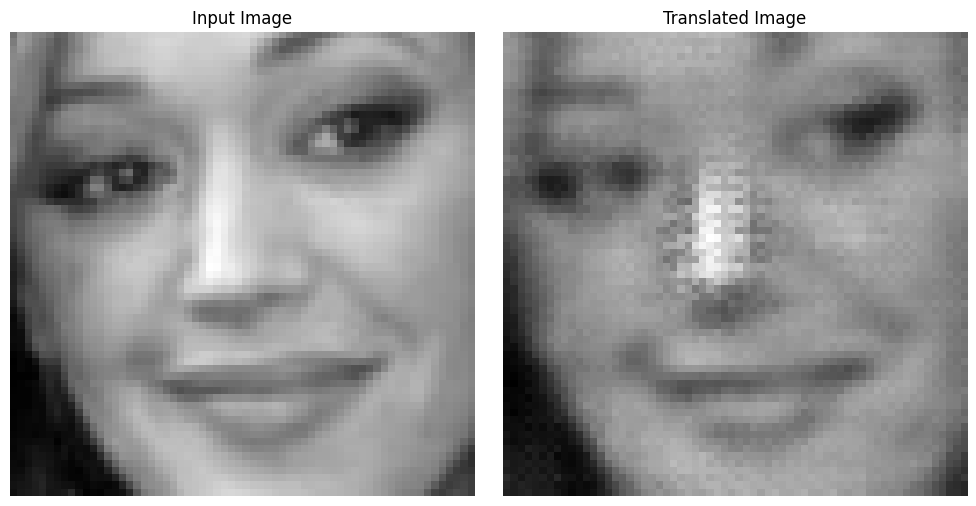

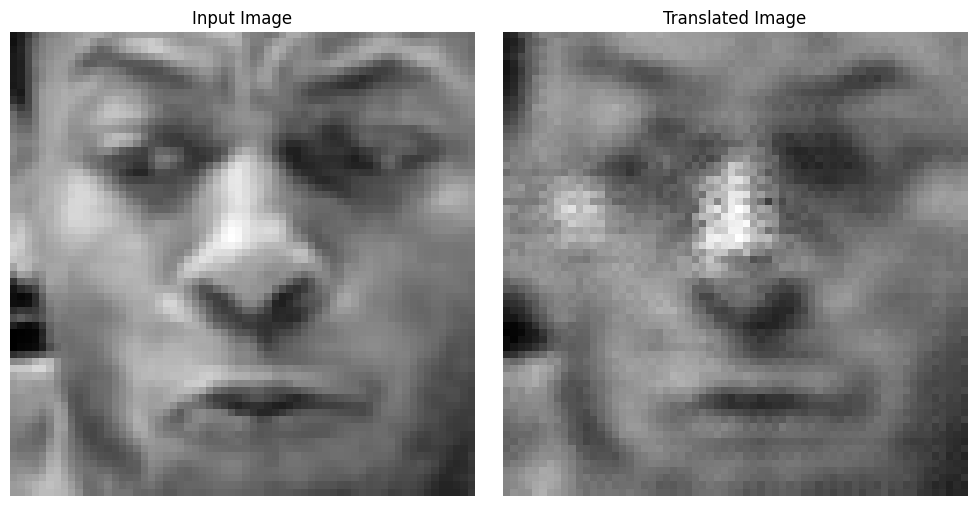

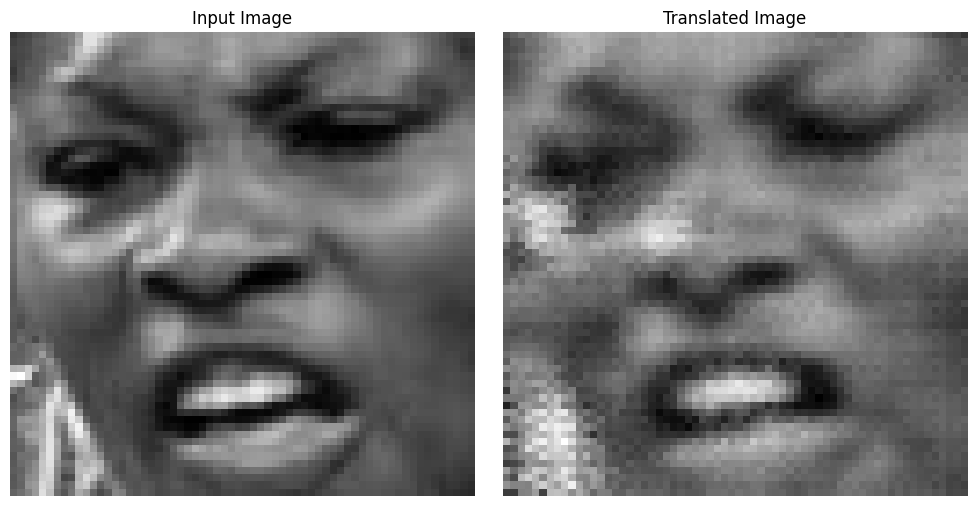

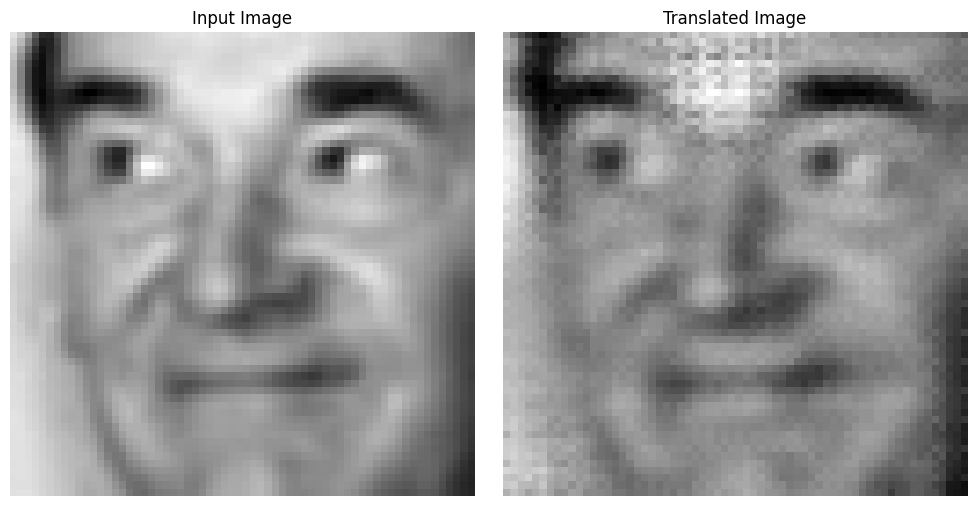

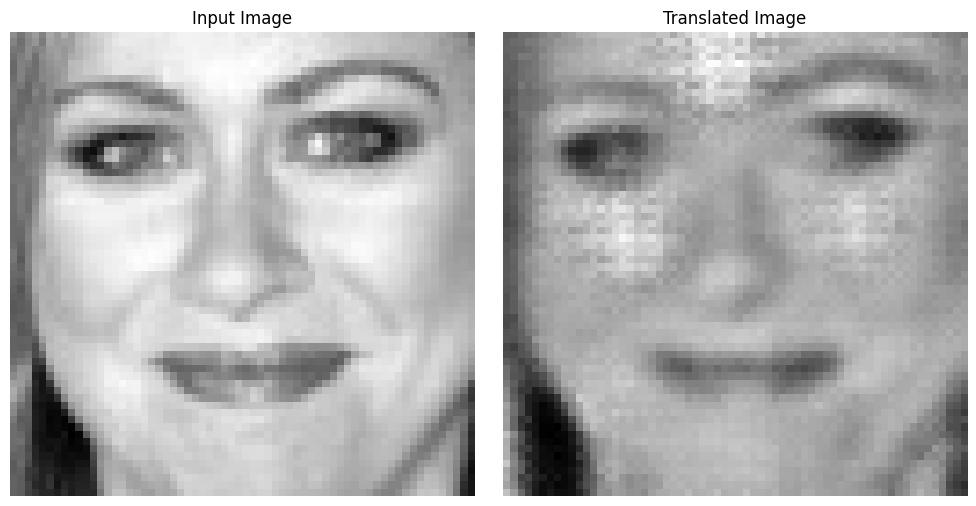

Starting epoch 2/20
Epoch 2 completed in 6022 seconds


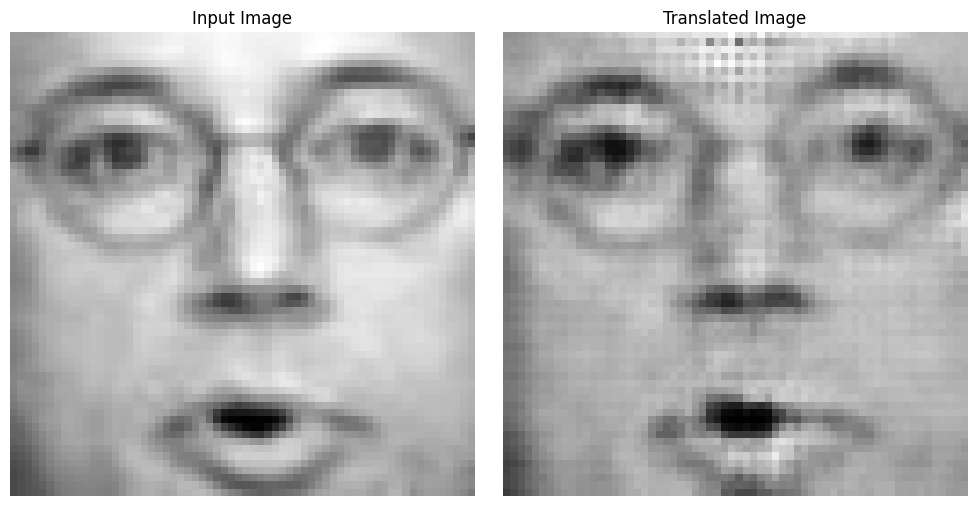

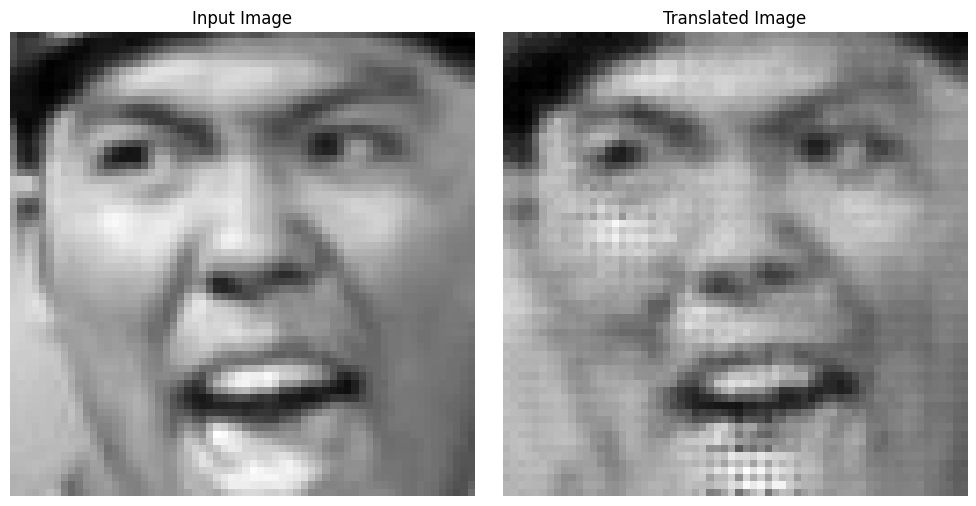

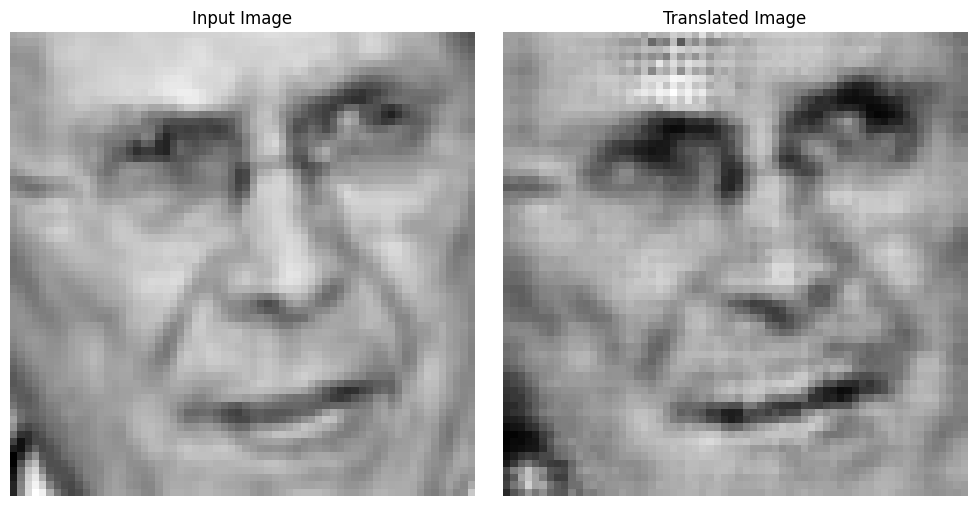

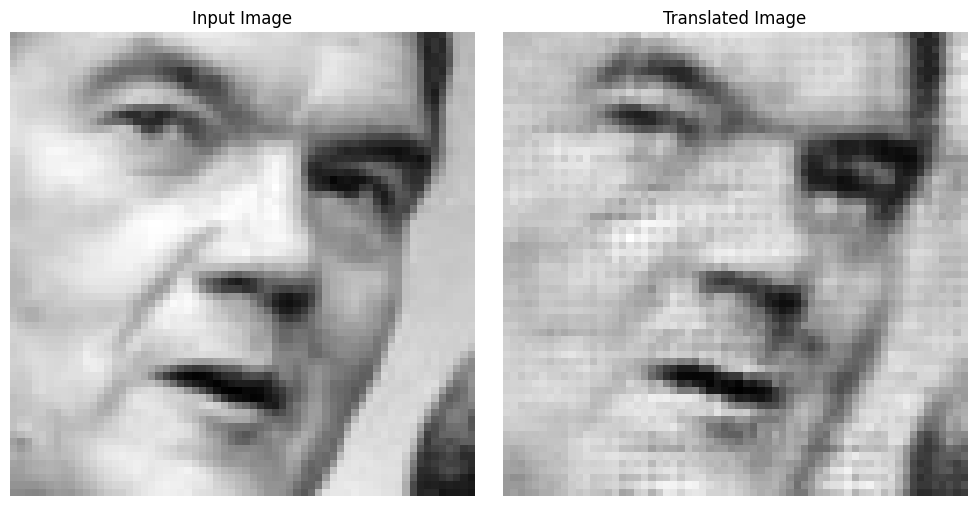

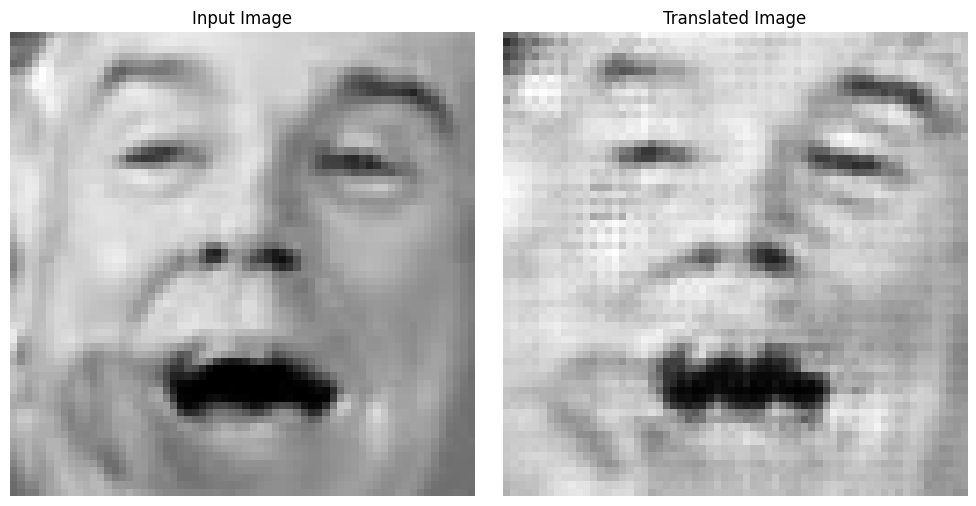

Starting epoch 3/20
Epoch 3 completed in 6073 seconds


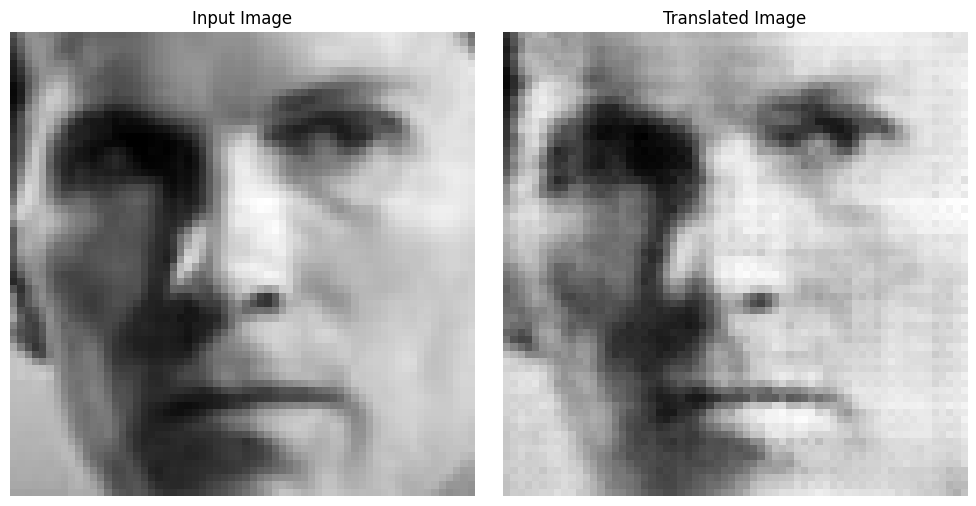

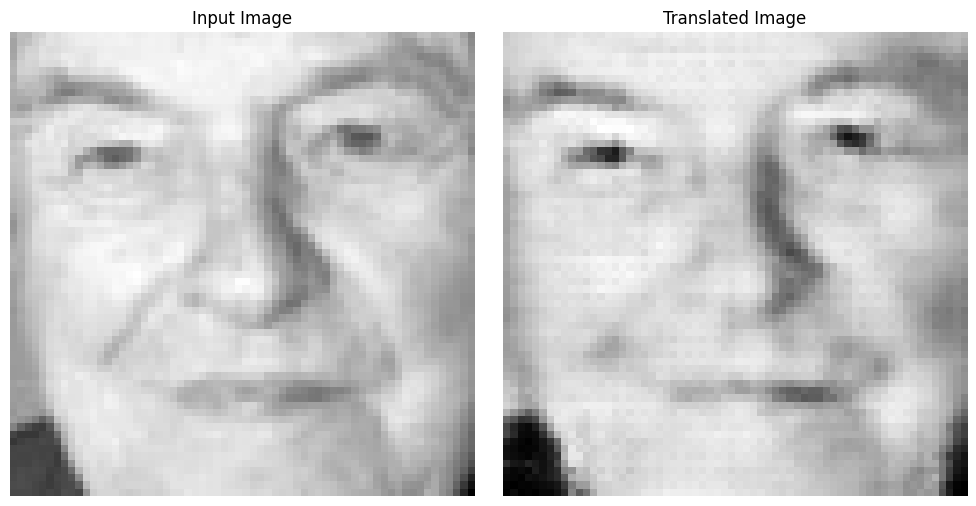

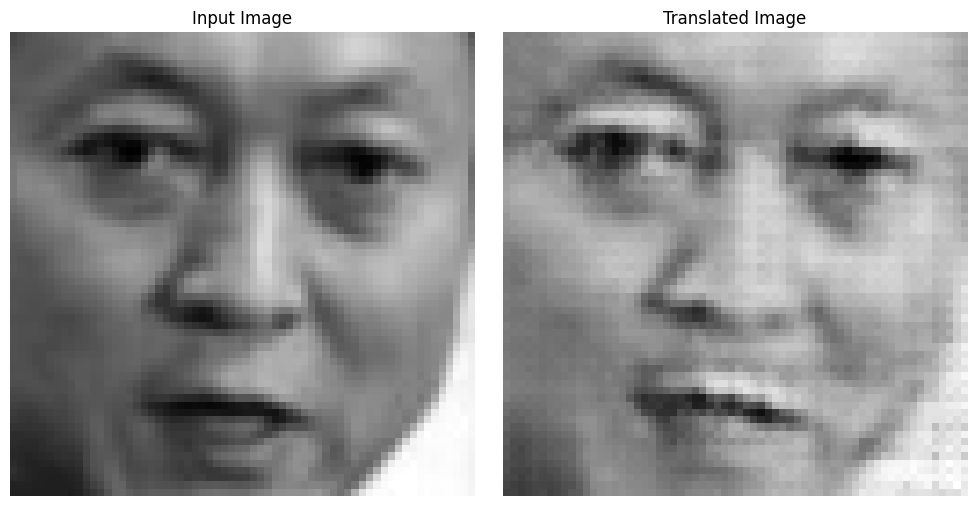

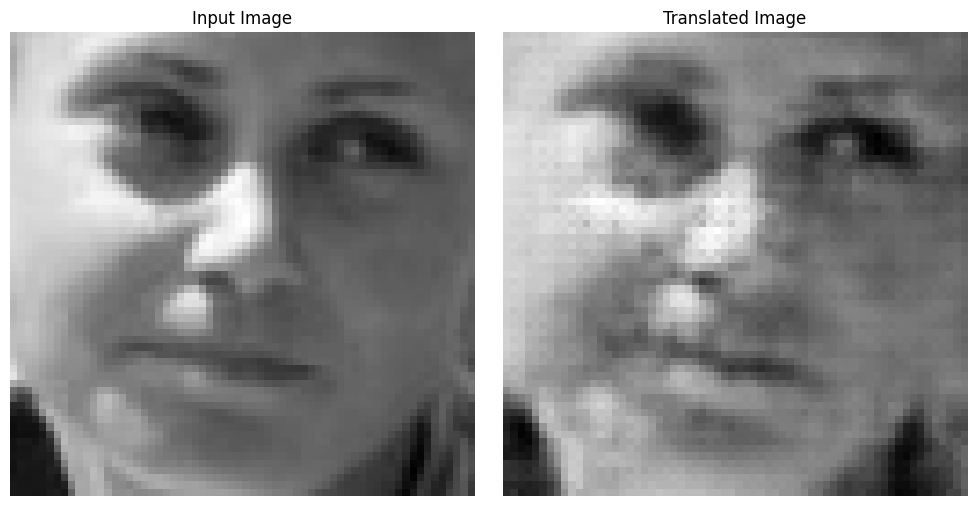

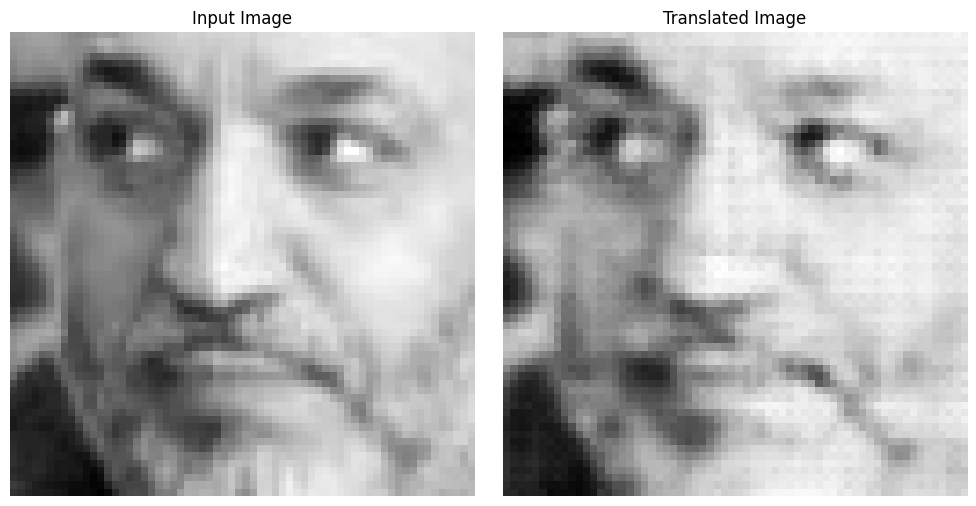

Starting epoch 4/20
Epoch 4 completed in 6019 seconds


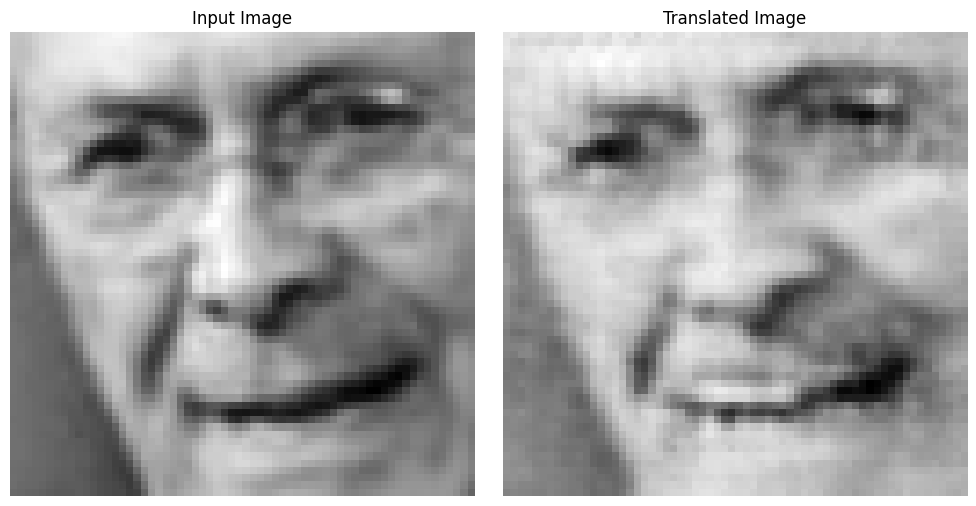

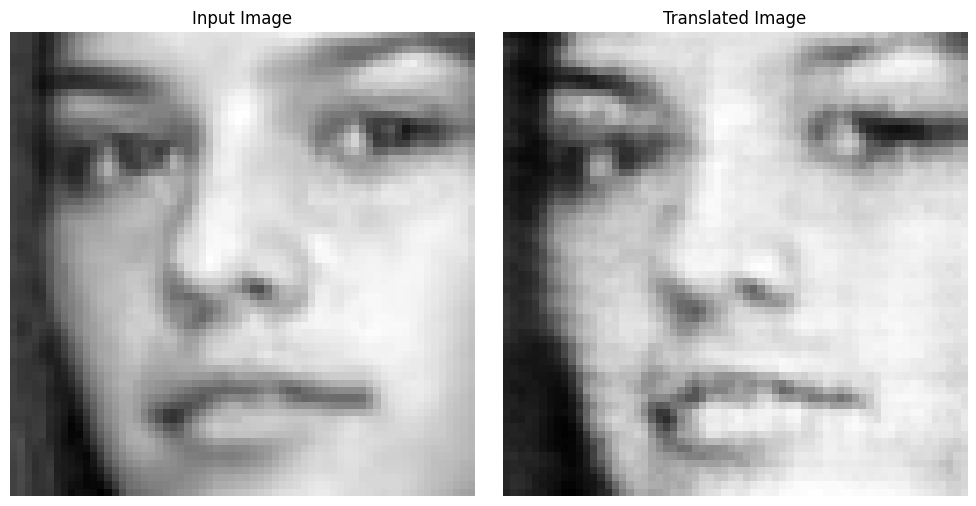

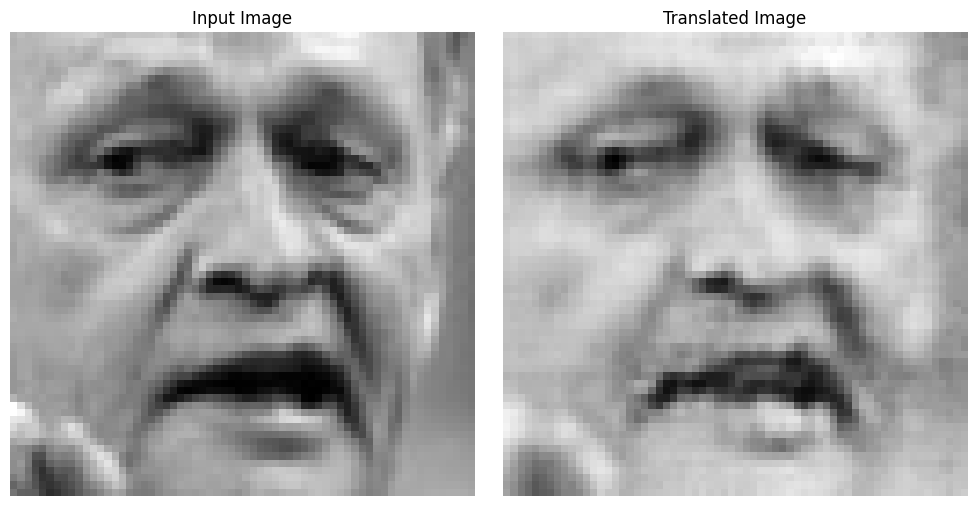

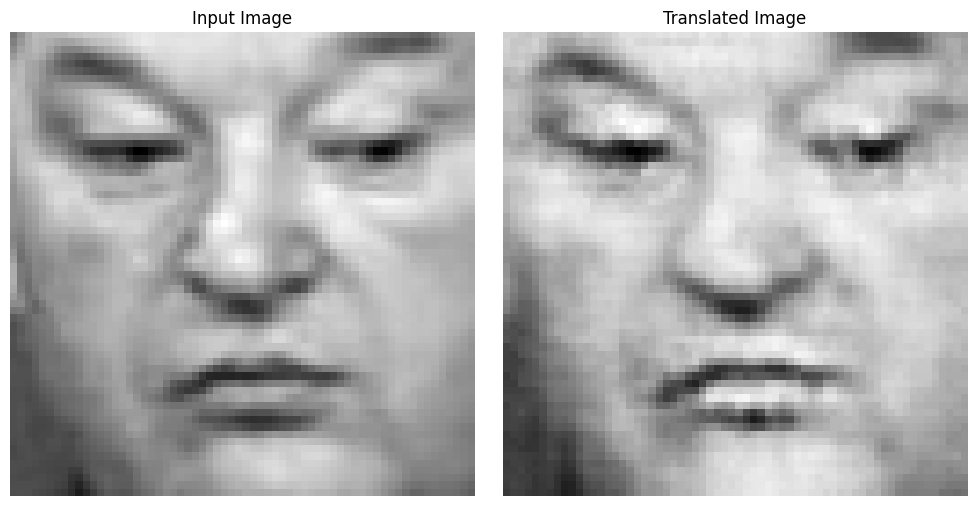

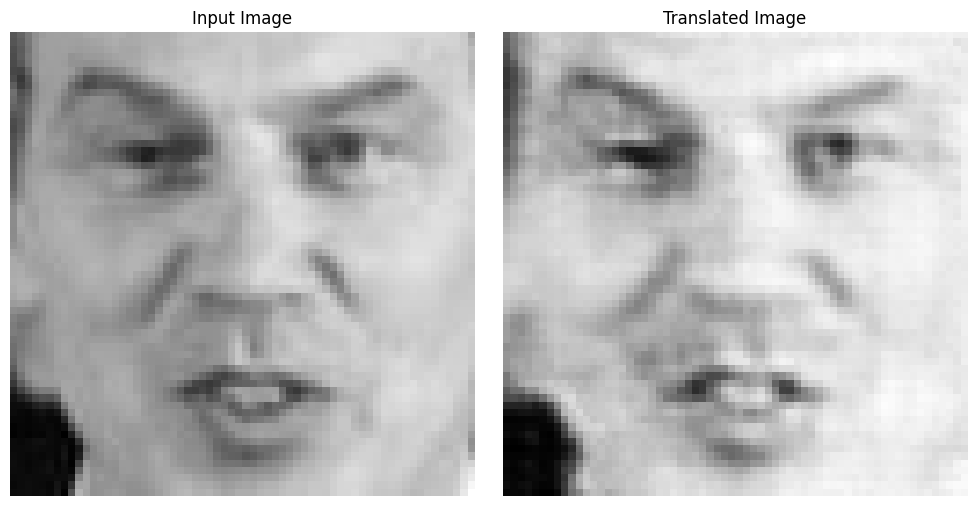

Starting epoch 5/20
Epoch 5 completed in 6029 seconds


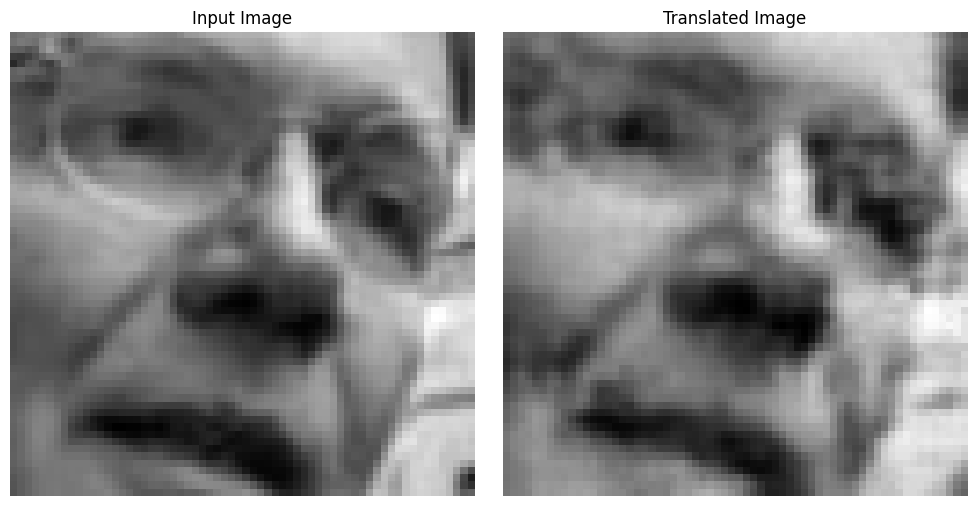

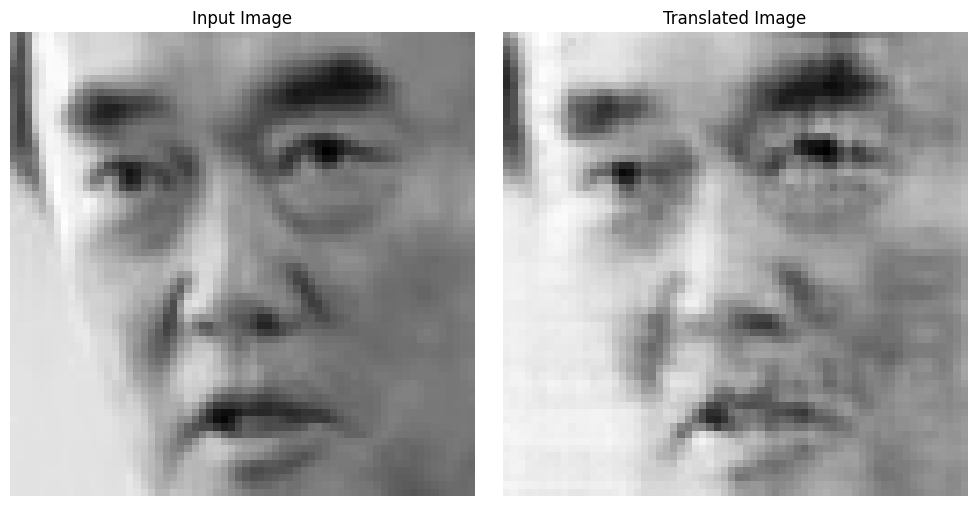

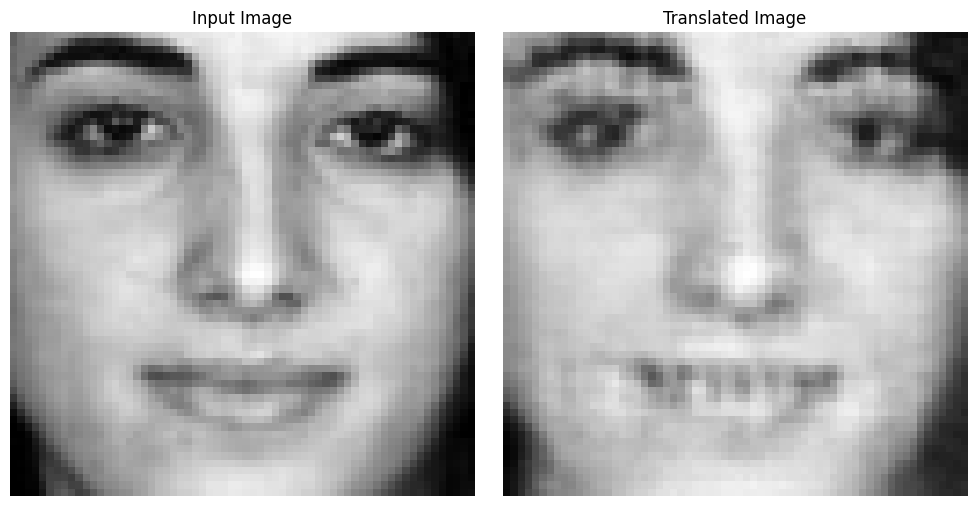

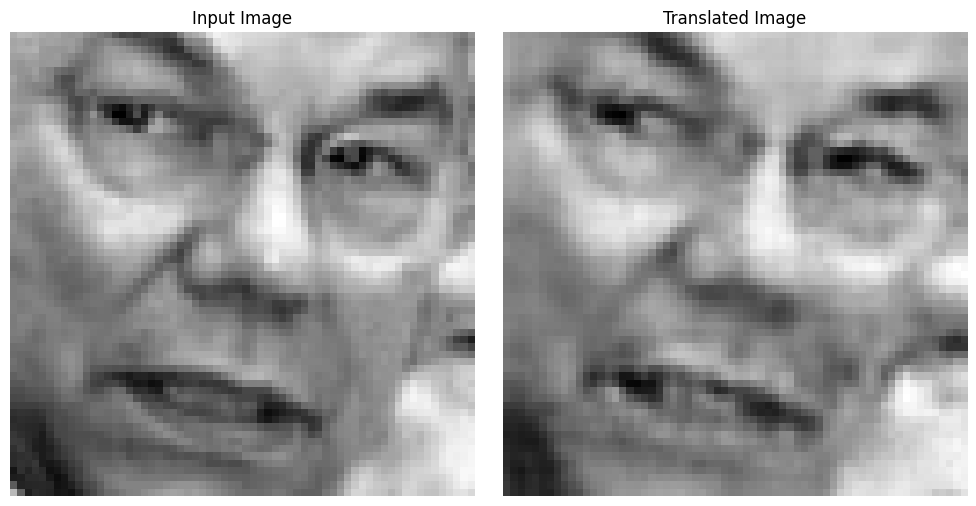

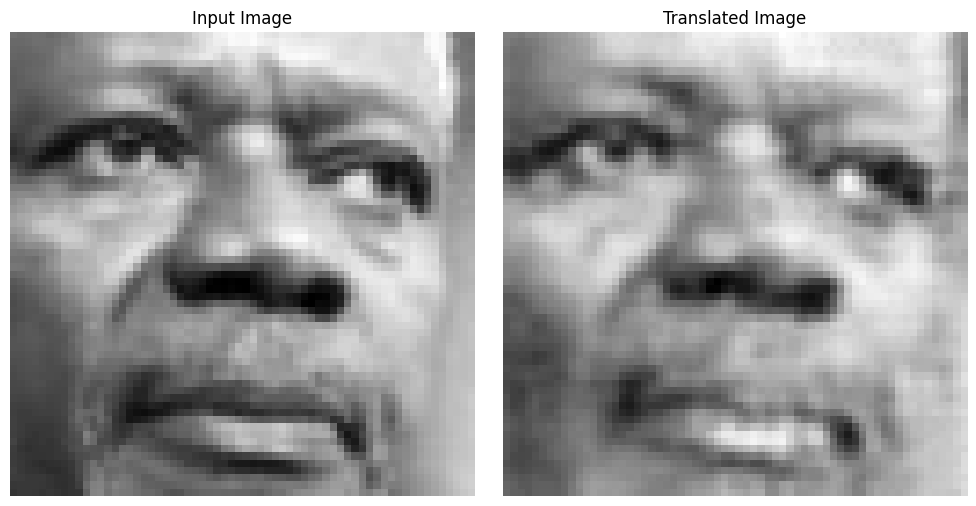

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Starting epoch 6/20
Epoch 6 completed in 6073 seconds


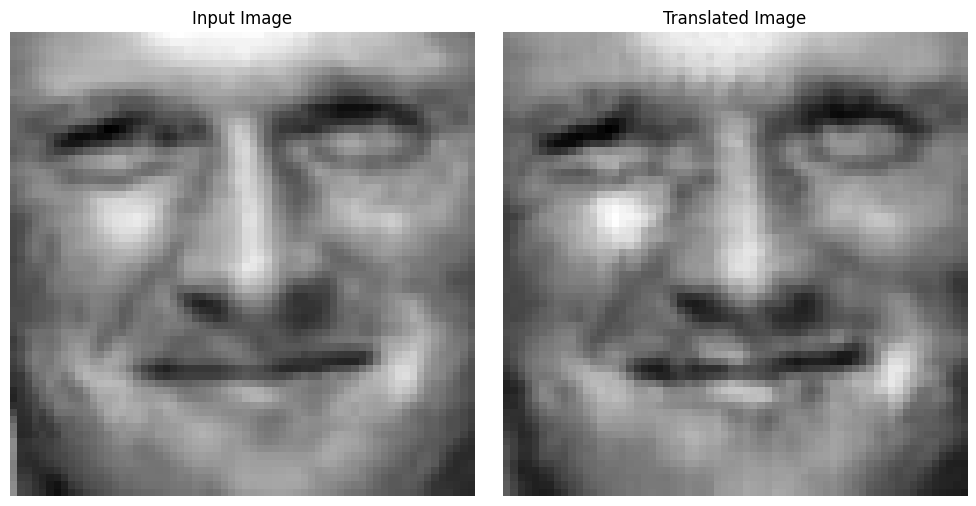

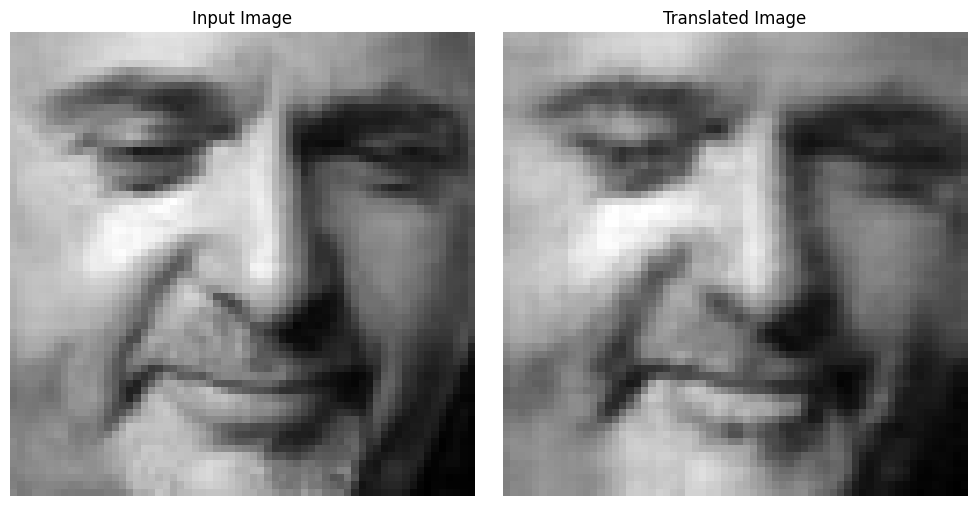

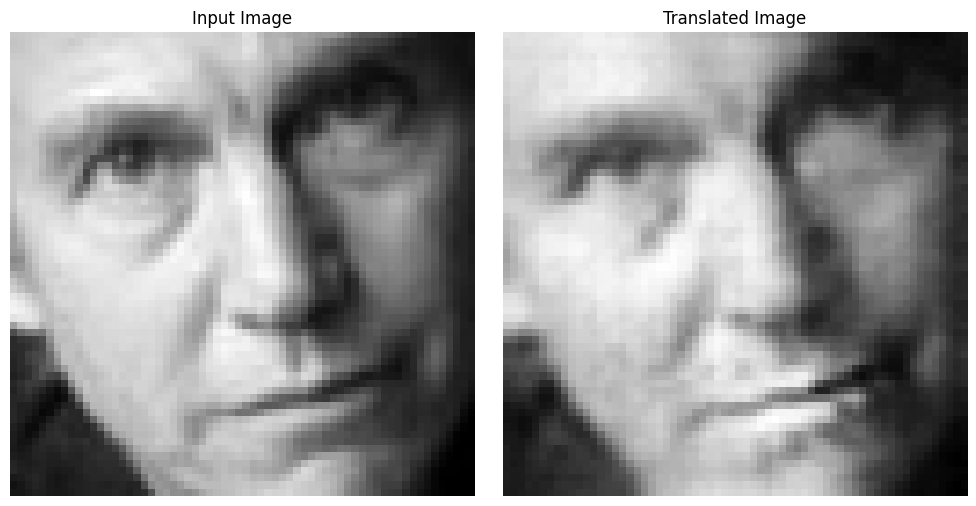

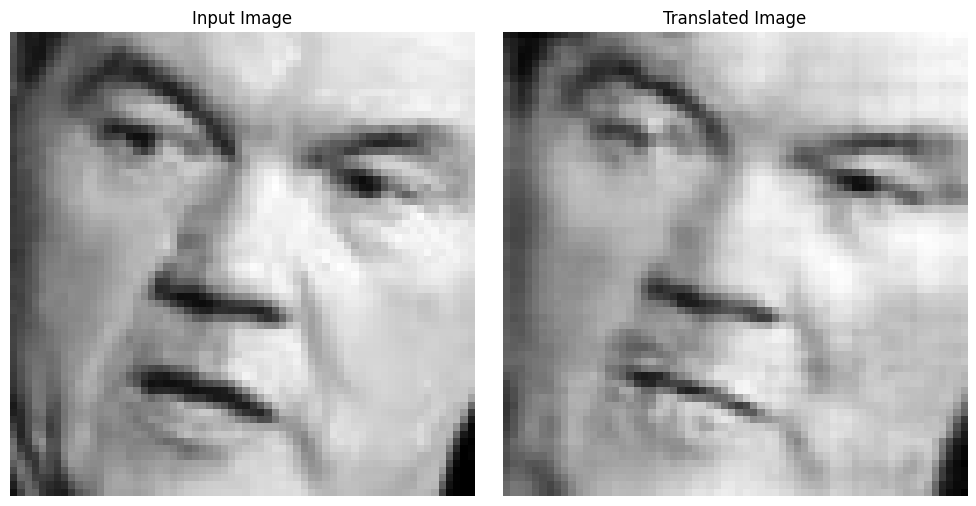

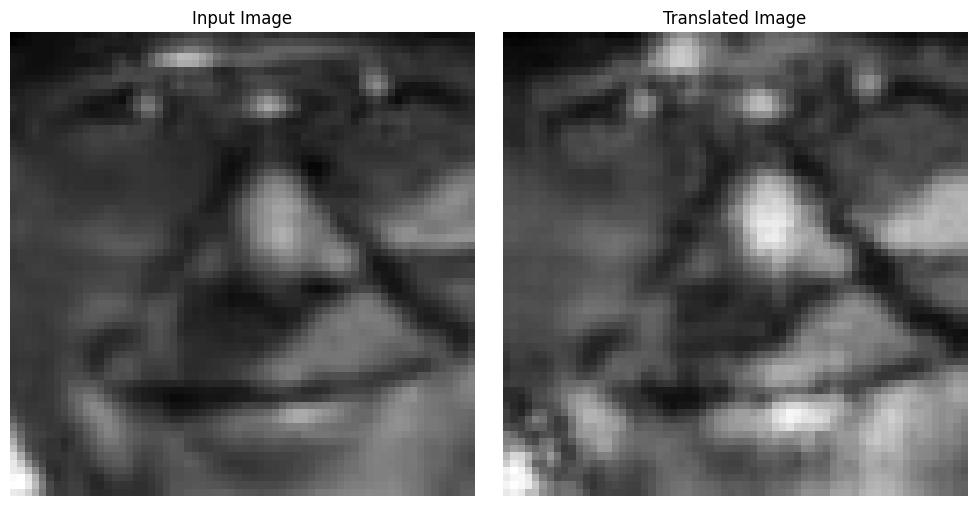

Starting epoch 7/20
Epoch 7 completed in 6001 seconds


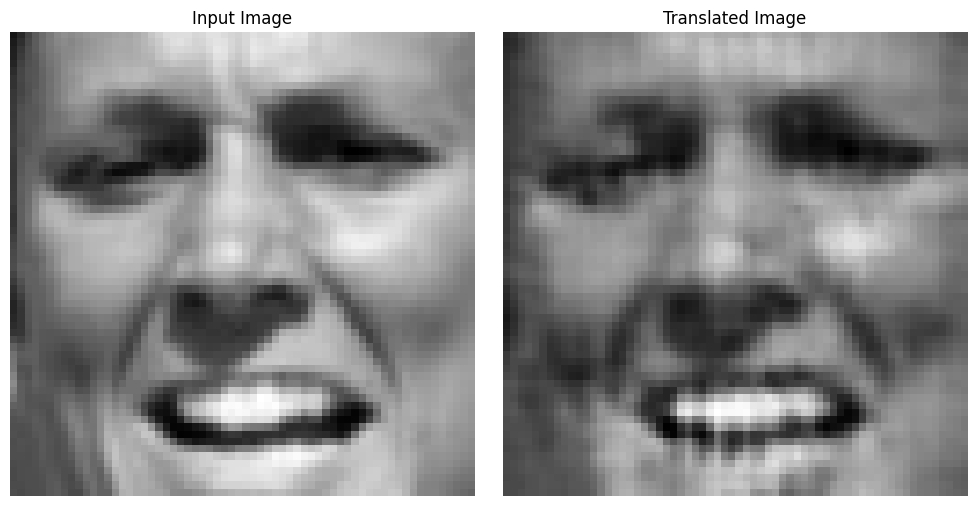

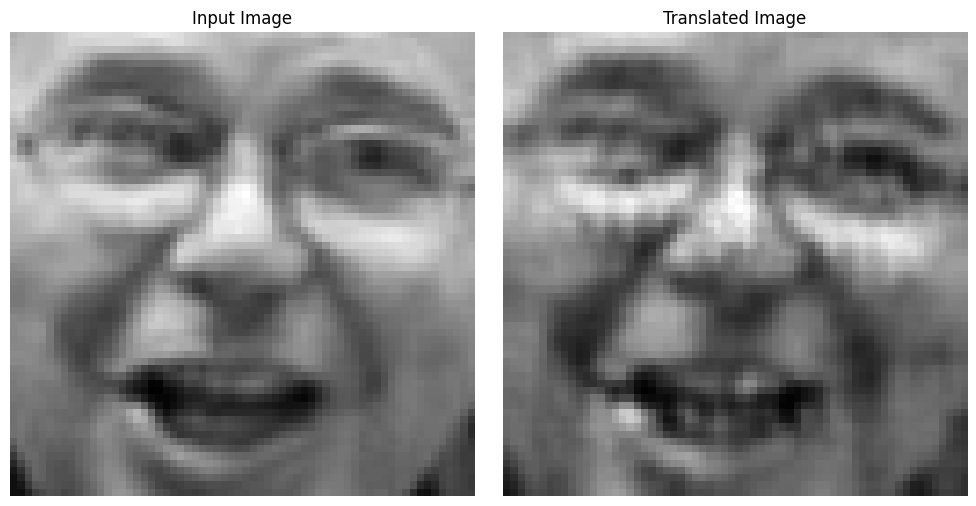

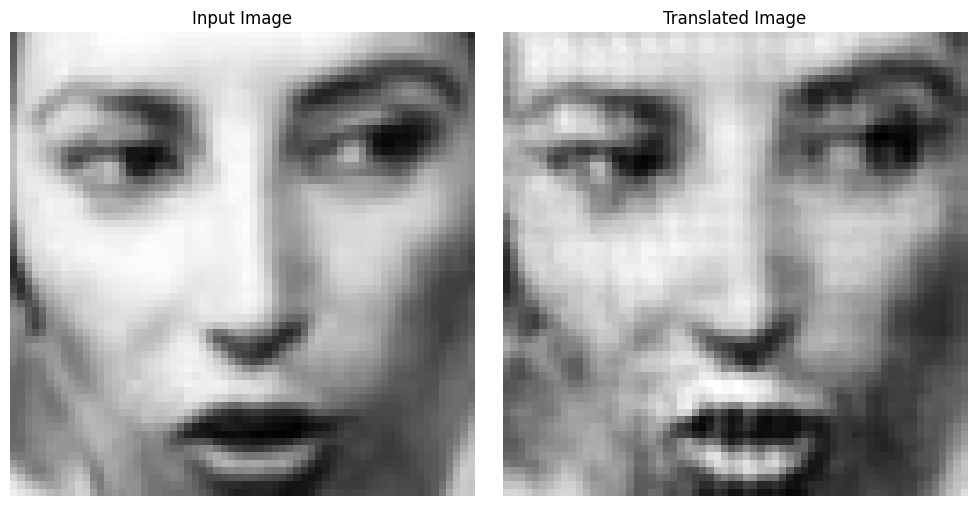

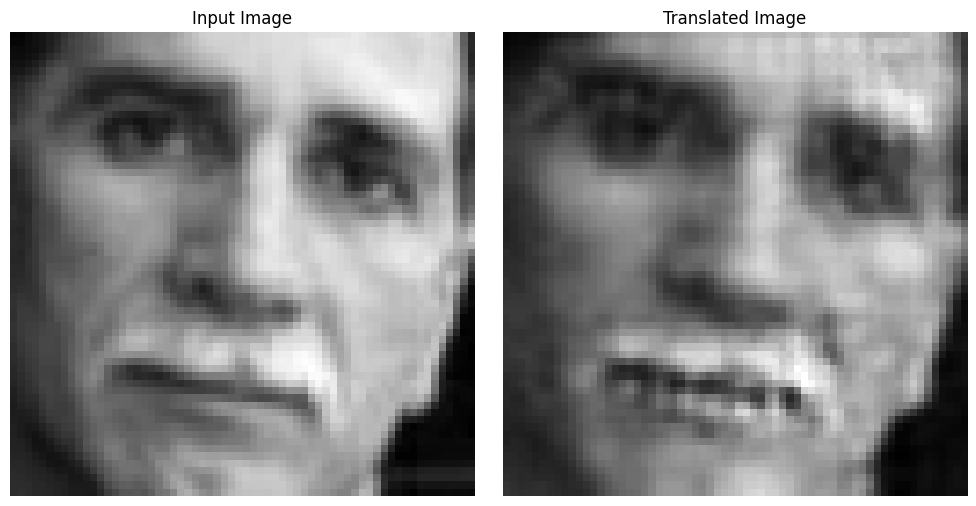

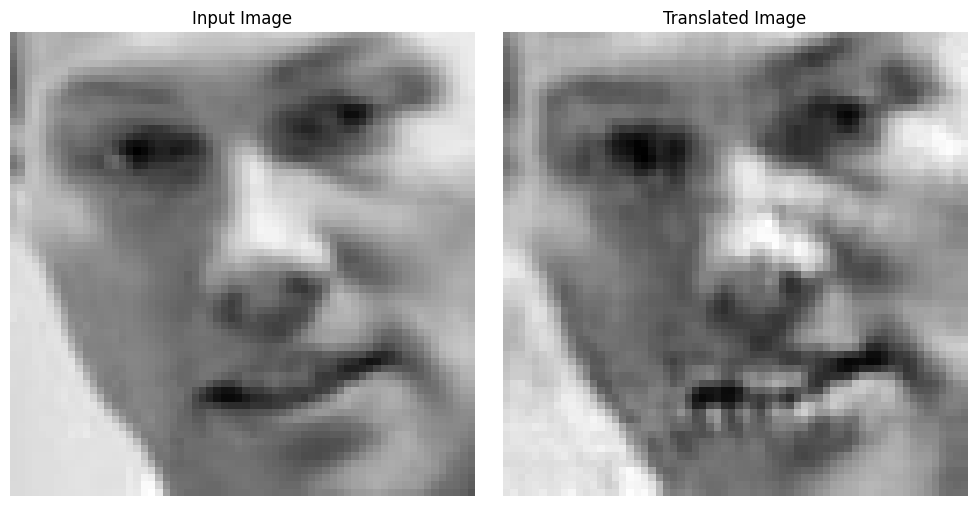

Starting epoch 8/20
Epoch 8 completed in 5920 seconds


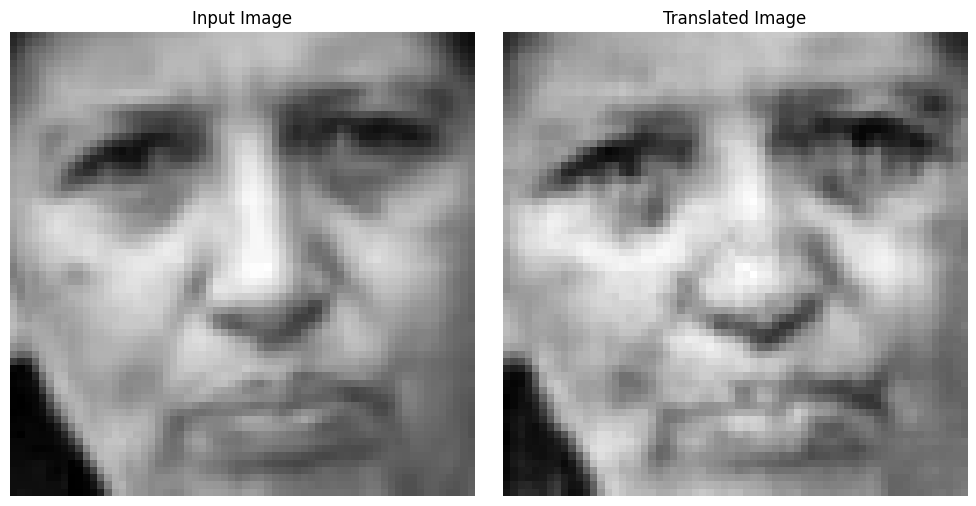

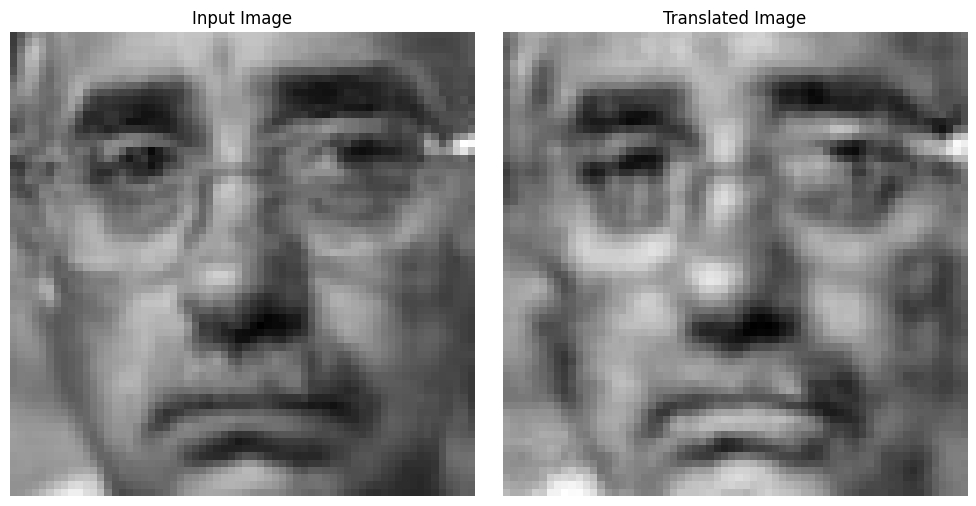

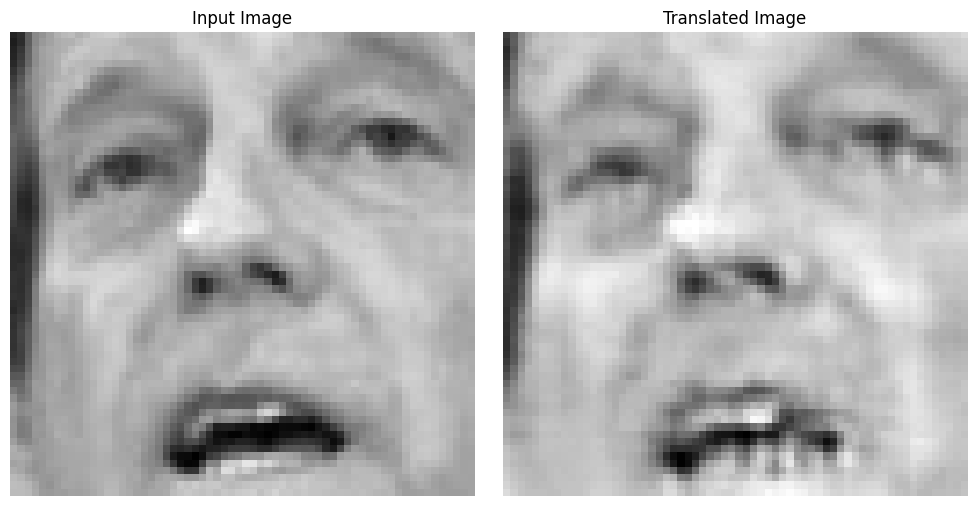

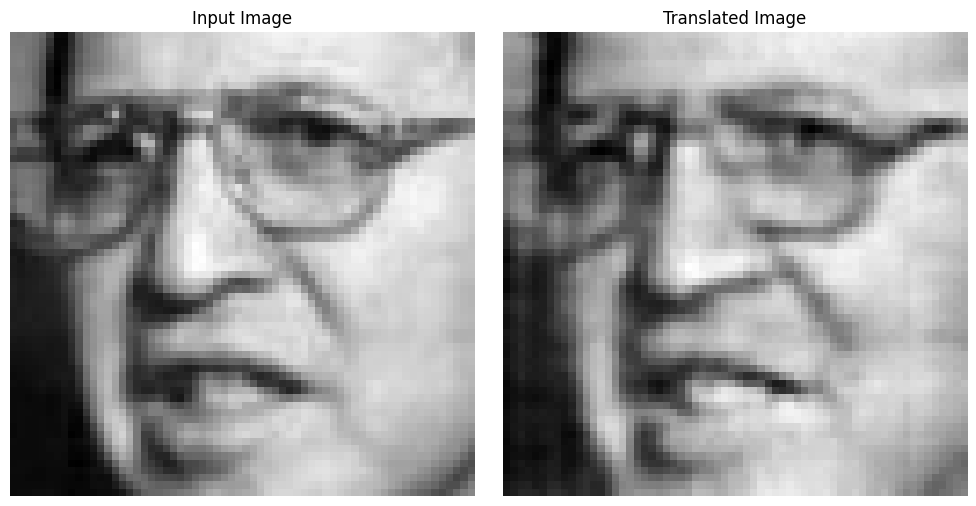

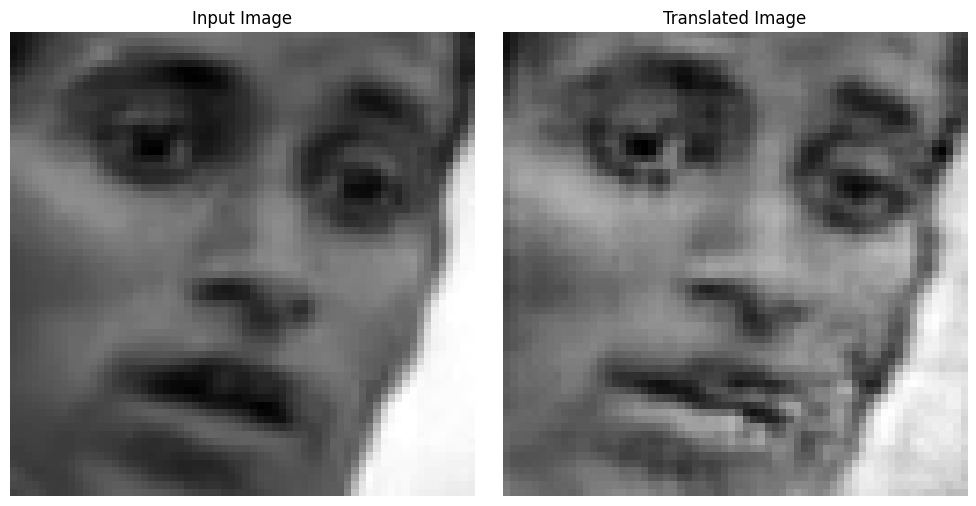

Starting epoch 9/20
Epoch 9 completed in 5990 seconds


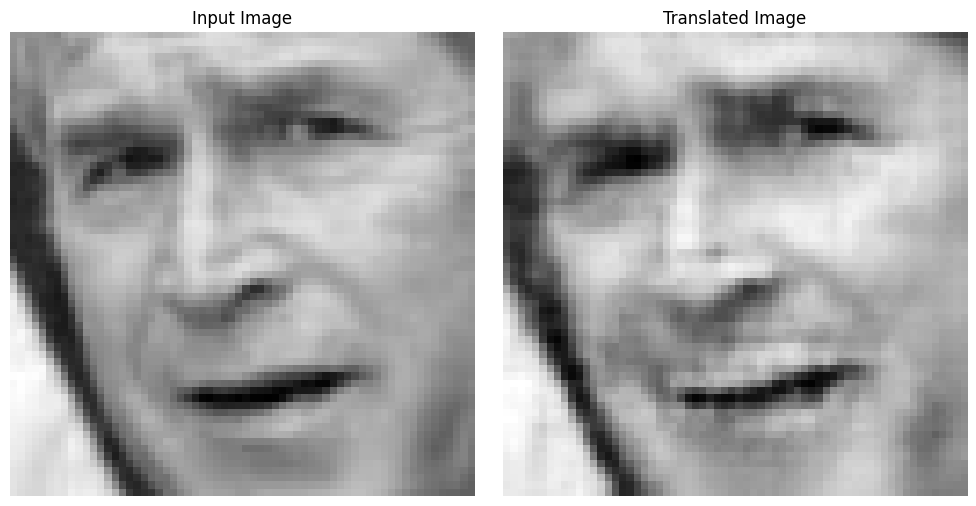

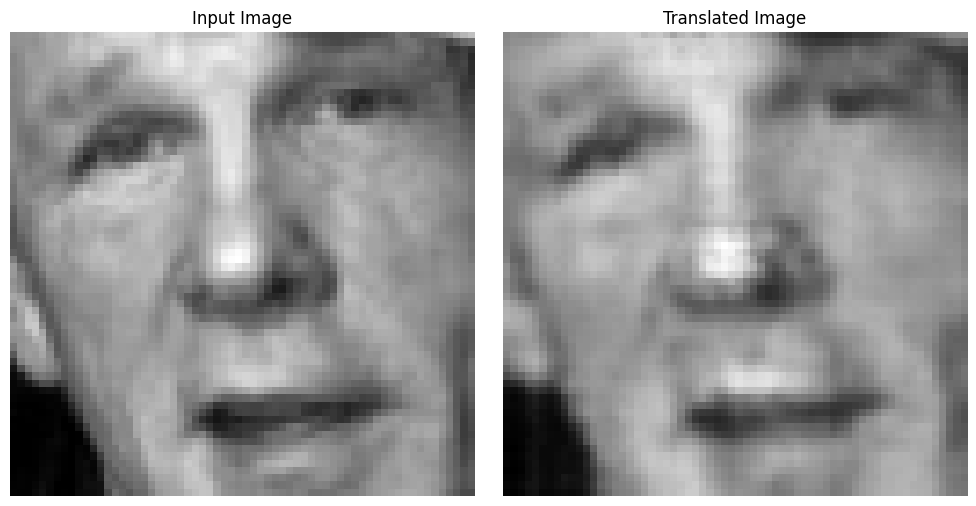

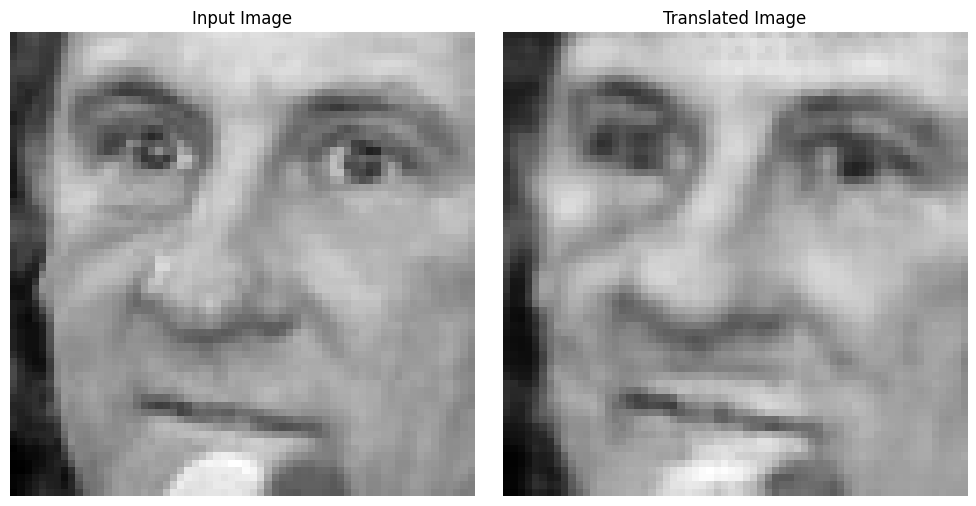

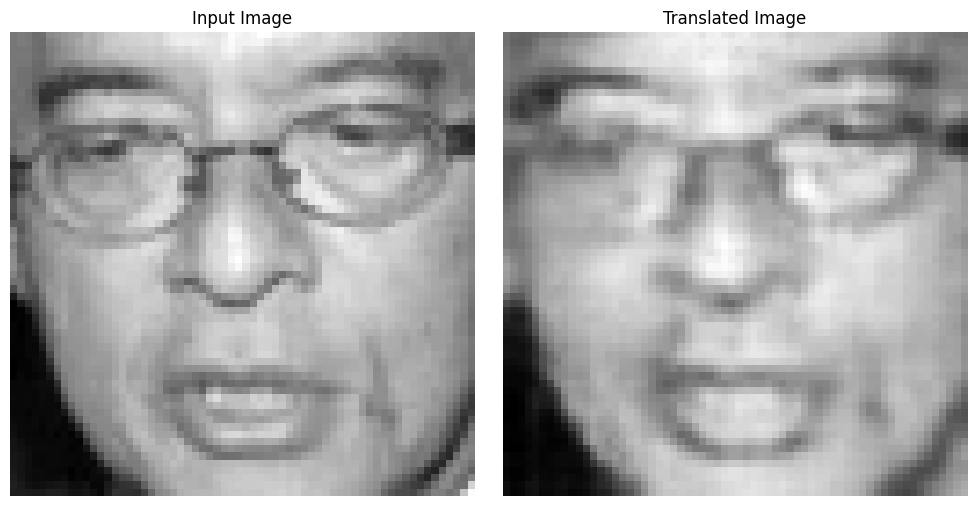

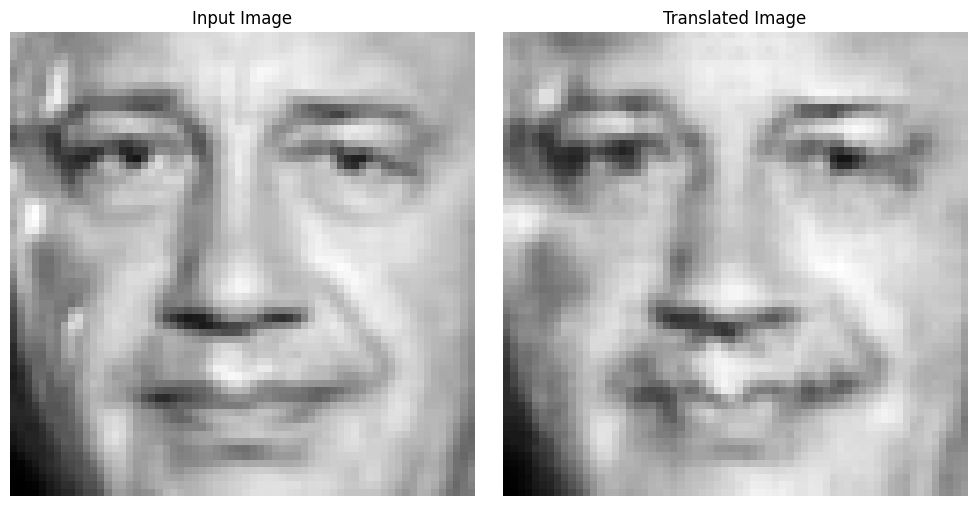

Starting epoch 10/20


KeyboardInterrupt: 

In [ ]:
# Function to generate and display sample outputs
def generate_images(model, test_input, epoch):
    prediction = model(test_input, training=False)
    for i in range(min(5, len(test_input))):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        img_input = (test_input[i].numpy() + 1) * 127.5  # Rescale to [0,255]
        plt.imshow(img_input.reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Translated Image')
        img_pred = (prediction[i].numpy() + 1) * 127.5  # Rescale to [0,255]
        plt.imshow(img_pred.reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Training loop
EPOCHS = 20  # Adjust the number of epochs as needed

print("Starting Training...")
for epoch in range(EPOCHS):
    start = time.time()
    print(f'Starting epoch {epoch+1}/{EPOCHS}')
    for real_x, real_y in tf.data.Dataset.zip((non_smiling_dataset, smiling_dataset)):
        train_step(real_x, real_y)
    print(f'Epoch {epoch+1} completed in {time.time()-start:.0f} seconds')

    # Generate and display images
    sample_non_smiling = next(iter(non_smiling_dataset.take(1)))
    generate_images(generator_g, sample_non_smiling, epoch+1)

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

print("Training completed.")

## **Conclusion**

The results of the current CycleGAN model, as visualized above, reveal significant shortcomings in its performance. While the generators attempt to translate non-smiling images to smiling ones and vice versa, the transformations are far from realistic. Instead of producing convincing outputs, the model often deforms the images, introducing artifacts and failing to preserve essential facial structures. This suggests that the model has not yet learned the underlying mappings between the two domains effectively. However for some images, we do see the smile formulating in the later epochs. We do also see an improvement in smile formation in the later epochs as compared to the earlier ones, which is proof that with more training, we would have been able to gain better results (relatively), even with the current configurations.

### Limitations of the Current Model
1. **Insufficient Training Epochs**:
   - The model was trained for only 10 epochs, which is not sufficient for the generators and discriminators to converge. As a result, the quality of the translations is subpar.

2. **Limited Batch Size**:
   - A small batch size was used during training, which may have restricted the model's ability to generalize effectively across the dataset.

3. **Loss Function Choices**:
   - While Binary Cross-Entropy (BCE) loss was used for adversarial training, it alone may not be sufficient to capture the fine-grained differences between real and generated images. Incorporating other loss functions, such as Mean Squared Error (MSE), could improve the model's ability to refine outputs.

4. **Time Constraints**:
   - Training the model for even 10 epochs required nearly three days, forcing us to stop early due to overlapping assignments and time limitations. Longer training would likely yield better results.

### **Plan for the Next Assignment**
To address these issues, the next assignment will implement several improvements:
1. **Increased Training Epochs**:
   - The model will be trained for 20 epochs to allow the generators and discriminators to better learn the mappings between domains.

2. **Larger Batch Size**:
   - A batch size of 16 will be used to improve gradient estimation and ensure better generalization across the dataset.

3. **Incorporation of MSE Loss**:
   - Mean Squared Error (MSE) will be incorporated alongside Binary Cross-Entropy (BCE) to better capture and refine structural similarities between real and generated images.

4. **Refinement of Hyperparameters**:
   - Optimizations will be made to the learning rate, $\lambda_{cycle}$ (cycle consistency weight), and $\lambda_{identity}$ (identity loss weight) to better balance adversarial training and structural preservation.

5. **Improved Training Pipeline**:
   - Adjustments to the data pipeline and computational resources will be made to expedite training, ensuring that the model can be trained more effectively without excessive delays.


### **Final Thoughts**
Although this iteration of the model fell short of expectations, it provided valuable insights into the challenges of adversarial training and domain translation. The lessons learned from this assignment will guide the improvements in the next iteration, enabling the model to produce higher-quality and more realistic translations. By addressing the limitations of the current model and incorporating new techniques, the final assignment will demonstrate significant advancements in facial expression translation and generative modeling. I have already started training the newer model, which incorporates these improvements (view the screenshot below) and the results are already looking more promising.

I plan to not only address the current model's limitations but also explore other techniques like StyleGAN for fine-grained control over facial features and StarGAN v2 for multi-domain image translation. These additions will represent a significant leap in the ability to generate diverse, photorealistic, and high-resolution transformations.

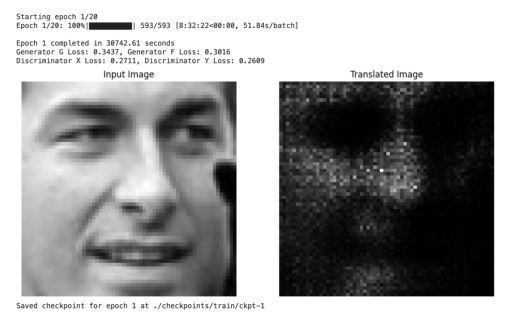

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your image
image_path = '/content/drive/MyDrive/Photography/CS156/Second Pipeline/image.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## New Model 1


New Model 1 builds upon the original architecture by incorporating several notable improvements designed to enhance training stability and image realism. First, we introduced a Mean Squared Error (MSE) loss term in the adversarial objective, which offers a smoother gradient landscape compared to binary cross-entropy. This adjustment encourages the generator to more finely adjust pixel values, resulting in more natural facial details. Additionally, we increased the batch size to optimize gradient estimation and facilitate more robust updates per training step, and modestly upped the training epochs to give the model extra time to converge on a stable solution.

Alongside these architectural and hyperparameter changes, we paid closer attention to data preprocessing, ensuring a balanced split of smiling and non-smiling images. We maintained the cycle-consistency and identity losses to preserve structural integrity, but the refined weighting of losses helped reduce the “muddy” artifacts seen in earlier attempts. The net effect is a model that captures more facial nuances, generating smiles that appear more purposeful and less distorted than in the baseline model.



In [9]:
########################################
# Create Datasets
#
# Now we create TensorFlow datasets from the processed directories.
# We will also normalize the images to [-1,1].
#
# If the processed images exist, we can proceed directly.
########################################

def normalize_img(img):
    """
    Normalize an image tensor from [0,255] to [-1,1].

    Args:
        img (tf.Tensor): Image tensor.

    Returns:
        tf.Tensor: Normalized image.
    """
    img = tf.cast(img, tf.float32)
    return (img / 127.5) - 1.0

if len(glob.glob(os.path.join(PROCESSED_SMILING_DIR, '*'))) > 0 and \
   len(glob.glob(os.path.join(PROCESSED_NON_SMILING_DIR, '*'))) > 0:
    print("Creating datasets...")

    smiling_ds = image_dataset_from_directory(
        PROCESSED_SMILING_DIR,
        labels=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(IMG_WIDTH, IMG_HEIGHT),
        shuffle=True,
        seed=42
    ).map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

    non_smiling_ds = image_dataset_from_directory(
        PROCESSED_NON_SMILING_DIR,
        labels=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(IMG_WIDTH, IMG_HEIGHT),
        shuffle=True,
        seed=42
    ).map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

    print("Datasets created successfully.")
else:
    raise RuntimeError("Processed images not found or incomplete. Cannot create datasets.")

Creating datasets...
Found 3690 files.
Found 3690 files.
Datasets created successfully.


In [10]:
########################################
# Define the CycleGAN Components
#
# We'll define:
# - ReflectionPadding2D
# - Residual Blocks
# - Downsample and Upsample functions
# - Generators and Discriminators with ResNet structure
#
# We'll keep the structure similar to the peer project and what we discussed.
########################################


kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_img_size = (IMG_HEIGHT, IMG_WIDTH, 3)

class ReflectionPadding2D(layers.Layer):
    """
    Reflection Padding Layer.

    Pads the given input tensor on the spatial dimensions with reflections of the tensor itself.
    """
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = tuple(padding)

    def call(self, input_tensor):
        p_h, p_w = self.padding
        return tf.pad(input_tensor, [[0,0],[p_h,p_h],[p_w,p_w],[0,0]], mode="REFLECT")

class InstanceNormalization(layers.Layer):
    """
    Instance Normalization Layer (replacement for tfa.layers.InstanceNormalization)
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=gamma_init,
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def residual_block(x, filters=32):
    """
    A single residual block as used in ResNet generator.
    Consists of two convolutional layers with instance normalization and a skip connection.
    """
    inp = x

    # First conv block
    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(filters, (3,3), padding="valid", kernel_initializer=kernel_init, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Second conv block
    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(filters, (3,3), padding="valid", kernel_initializer=kernel_init, use_bias=False)(x)
    x = InstanceNormalization()(x)

    # Skip connection
    return layers.add([inp, x])

def downsample(x, filters):
    """
    Downsampling layer to reduce spatial dimension and increase feature dimension.
    """
    x = layers.Conv2D(filters, (3,3), strides=2, padding="same", kernel_initializer=kernel_init, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    return x

def upsample(x, filters):
    """
    Upsampling layer to increase spatial dimension (using Conv2DTranspose).
    """
    x = layers.Conv2DTranspose(filters, (3,3), strides=2, padding="same", kernel_initializer=kernel_init, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    return x

def get_resnet_generator(filters=64, num_residual_blocks=6, name=None):
    """
    Builds a ResNet-based generator network.

    Args:
        filters (int): Base number of filters.
        num_residual_blocks (int): Number of residual blocks to use.
        name (str): Name of the model.

    Returns:
        keras.Model: A compiled generator model.
    """
    inputs = layers.Input(shape=input_img_size, name=name+"_img_input")

    # Initial block
    x = ReflectionPadding2D((3,3))(inputs)
    x = layers.Conv2D(filters, (7,7), kernel_initializer=kernel_init, use_bias=False, padding="valid")(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = downsample(x, filters*2)
    x = downsample(x, filters*4)

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters=filters*4)

    # Upsampling
    x = upsample(x, filters*2)
    x = upsample(x, filters)

    # Final block
    x = ReflectionPadding2D((3,3))(x)
    x = layers.Conv2D(3, (7,7), padding="valid", kernel_initializer=kernel_init)(x)
    x = layers.Activation("tanh")(x)

    return keras.Model(inputs, x, name=name)

def get_discriminator(filters=64, name=None):
    """
    Builds a PatchGAN discriminator.

    Args:
        filters (int): Base number of filters.
        name (str): Name of the model.

    Returns:
        keras.Model: A discriminator model.
    """
    inputs = layers.Input(shape=input_img_size, name=name+"_img_input")
    x = layers.Conv2D(filters, (4,4), strides=2, padding="same", kernel_initializer=kernel_init)(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters*2, (4,4), strides=2, padding="same", kernel_initializer=kernel_init, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters*4, (4,4), strides=2, padding="same", kernel_initializer=kernel_init, use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, (4,4), padding="same", kernel_initializer=kernel_init)(x)
    return keras.Model(inputs, x, name=name)


In [13]:
# Define CycleGAN Class
#
# This class handles the training step for the CycleGAN,
# including the cycle consistency, identity, and adversarial losses.
########################################
########################################
# Define CycleGAN Class
########################################

class CycleGan(keras.Model):
    """
    CycleGAN model that handles:
    - Forward translation (X->Y)
    - Backward translation (Y->X)
    - Cycle consistency losses
    - Identity losses
    - Adversarial losses
    """

    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10.0, lambda_identity=0.5):
        super().__init__()
        self.gen_G = generator_G     # X -> Y
        self.gen_F = generator_F     # Y -> X
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer, disc_Y_optimizer, gen_loss_fn, disc_loss_fn):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Forward translation: X->Y
            fake_y = self.gen_G(real_x, training=True)
            # Backward translation: Y->X
            fake_x = self.gen_F(real_y, training=True)

            # Cycle: X->Y->X
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle: Y->X->Y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator predictions
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator losses (adversarial)
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Cycle losses
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Identity losses
            id_loss_G = self.identity_loss_fn(real_y, same_y) * self.lambda_cycle * self.lambda_identity
            id_loss_F = self.identity_loss_fn(real_x, same_x) * self.lambda_cycle * self.lambda_identity

            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator losses
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Compute gradients
        gen_G_grads = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        gen_F_grads = tape.gradient(total_loss_F, self.gen_F.trainable_variables)
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Apply gradients
        self.gen_G_optimizer.apply_gradients(zip(gen_G_grads, self.gen_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(gen_F_grads, self.gen_F.trainable_variables))
        self.disc_X_optimizer.apply_gradients(zip(disc_X_grads, self.disc_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, self.disc_Y.trainable_variables))

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [14]:
########################################
# Create Generators and Discriminators
########################################

gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

########################################
# Define Loss Functions for Adversarial
#
# We use MSE as the peer project did.
########################################

adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    """
    Generator adversarial loss.
    The generator wants the discriminator to classify generated images as real (1s).
    """
    return adv_loss_fn(tf.ones_like(fake), fake)

def discriminator_loss_fn(real, fake):
    """
    Discriminator adversarial loss.
    Discriminator should classify real images as 1s and fake images as 0s.
    """
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


In [15]:
########################################
# Initialize and Compile the CycleGAN Model
########################################

cycle_gan_model = CycleGan(
    generator_G=gen_G,
    generator_F=gen_F,
    discriminator_X=disc_X,
    discriminator_Y=disc_Y,
    lambda_cycle=10.0,
    lambda_identity=0.5
)

cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)


In [16]:
########################################
# Prepare Data for Training
#
# We zip the non_smiling_ds and smiling_ds so that each batch contains
# a batch of non-smiling images (X) and a batch of smiling images (Y).
########################################

train_dataset = tf.data.Dataset.zip((non_smiling_ds, smiling_ds))

# Extract a sample image from non_smiling_ds to track progress
sample_batch = next(iter(non_smiling_ds.take(1)))
sample_image = sample_batch[0]  # First image from the batch


In [17]:
########################################
# Define Callbacks and Helper Functions
########################################

class GANMonitor(keras.callbacks.Callback):
    """
    A callback to generate and save images after each epoch
    """
    def __init__(self, test_image, save_dir="generated_images"):
        super().__init__()
        self.test_image = test_image
        os.makedirs(save_dir, exist_ok=True)
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Generate image using G
        prediction = self.model.gen_G(tf.expand_dims(self.test_image, 0))[0]

        # Plot and save
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow((self.test_image * 0.5 + 0.5).numpy())
        plt.title('Original')
        plt.axis('off')

        # Generated image
        plt.subplot(1, 2, 2)
        plt.imshow((prediction * 0.5 + 0.5).numpy())
        plt.title('Generated')
        plt.axis('off')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch+1}.png'))
        plt.close()

        # CHANGED: Print a message to show results are ready right after the epoch ends
        print(f"Finished epoch {epoch+1}, saved generated image to {self.save_dir}")

# Create checkpoint callback
checkpoint_prefix = os.path.join('training_checkpoints', 'ckpt')
checkpoint = tf.train.Checkpoint(
    cycle_gan=cycle_gan_model,
    gen_G=gen_G,
    gen_F=gen_F,
    disc_X=disc_X,
    disc_Y=disc_Y
)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    checkpoint_prefix,
    max_to_keep=1
)


In [20]:
########################################
# Start Training
########################################

# Training parameters
steps_per_epoch = len(train_dataset)

# Create the monitor callback
monitor_callback = GANMonitor(sample_image)

# Create a directory for saving model weights
if not os.path.exists('saved_model'):
    os.makedirs('saved_model')

print("Starting training...")
history = cycle_gan_model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[monitor_callback]
)

# Save the final model
gen_G.save('saved_model/generator_G')
gen_F.save('saved_model/generator_F')
print("Training completed and models saved!")

Starting training...
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - D_X_loss: 0.2675 - D_Y_loss: 0.2668 - F_loss: 3.0779 - G_loss: 3.0434Finished epoch 1, saved generated image to generated_images
58/58 ━━━━━━━━━━━━━━━━━━━━ 283s 5s/step - D_X_loss: 0.2671 - D_Y_loss: 0.2663 - F_loss: 3.0714 - G_loss: 3.0384
Epoch 2/20
Finished epoch 2, saved generated image to generated_images
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - D_X_loss: 0.2397 - D_Y_loss: 0.2364 - F_loss: 2.6904 - G_loss: 2.7473
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - D_X_loss: 0.2146 - D_Y_loss: 0.2144 - F_loss: 2.7078 - G_loss: 2.7031Finished epoch 3, saved generated image to generated_images
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - D_X_loss: 0.2138 - D_Y_loss: 0.2141 - F_loss: 2.7065 - G_loss: 2.7019
Epoch 4/20
Finished epoch 4, saved generated image to generated_images
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - D_X_loss: 0.1707 - D_Y_loss: 0.1968 - F_loss: 2.6300 - G_loss: 2.6324
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - D_X_loss: 0.1856 - D_Y_loss: 0.1862 - F_loss: 2.7354 - G_loss: 2.7021Finished epoch 5, saved generated image to generated_images
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - D_X_loss: 0.1858 - D_Y_loss: 0.1858 - F_loss: 2.7340 - G_loss: 2.7114
Epoch 6/20
Finished epoch 6, saved generated image to generated_images
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - D_X_loss: 0.1950 - D_Y_loss: 0.1615 - F_loss: 2.6505 - G_loss: 3.2462
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step -

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model/generator_G.

In [21]:
gen_G.save('saved_model/generator_G.keras')
gen_F.save('saved_model/generator_F.keras')


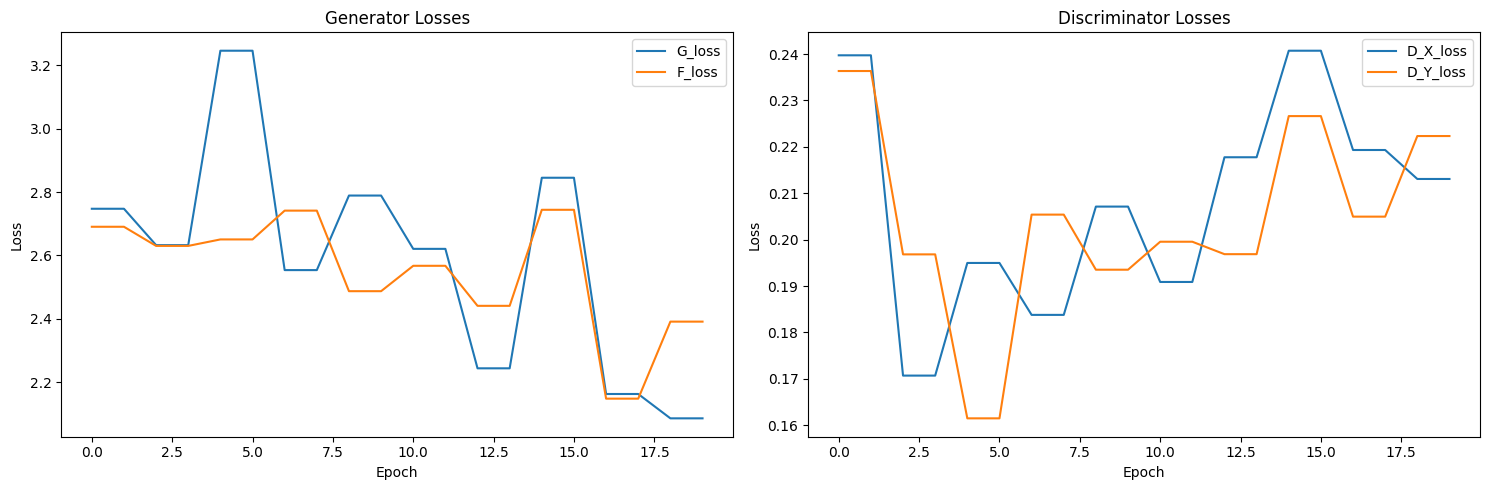

In [22]:
########################################
# Plot Training History
########################################

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Plot generator losses
    plt.subplot(1, 2, 1)
    plt.plot(history.history['G_loss'], label='G_loss')
    plt.plot(history.history['F_loss'], label='F_loss')
    plt.title('Generator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot discriminator losses
    plt.subplot(1, 2, 2)
    plt.plot(history.history['D_X_loss'], label='D_X_loss')
    plt.plot(history.history['D_Y_loss'], label='D_Y_loss')
    plt.title('Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

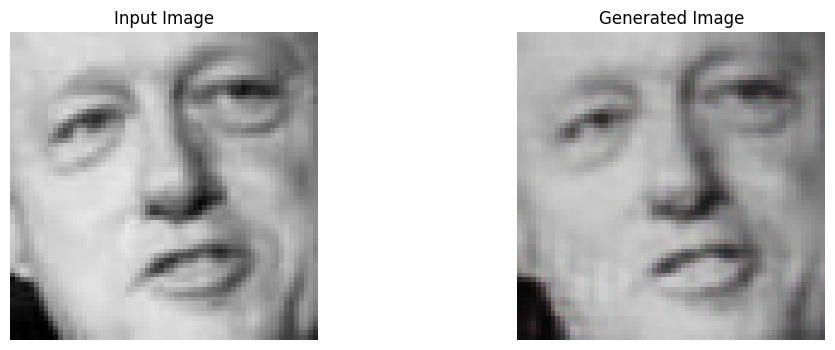

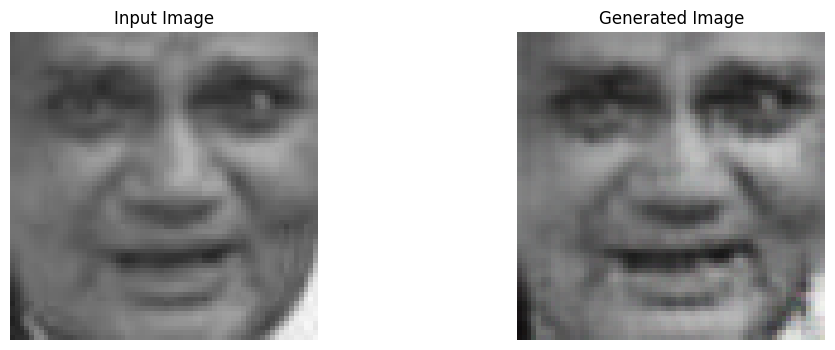

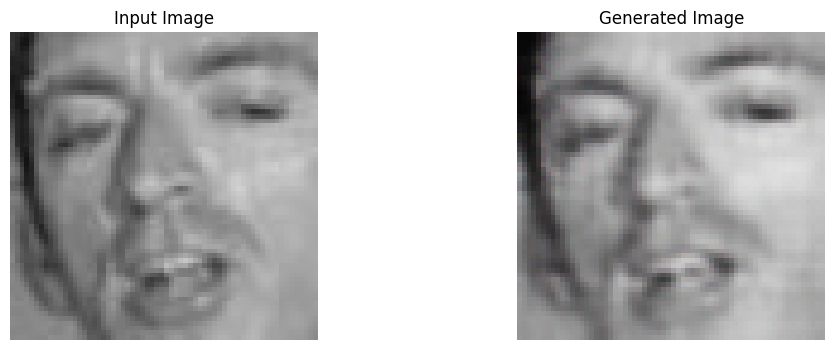

In [25]:
########################################
# Test the Trained Model
########################################

def generate_images(test_input):
    prediction = gen_G(tf.expand_dims(test_input, 0))[0]

    plt.figure(figsize=(12, 4))

    display_list = [test_input, prediction]
    title = ['Input Image', 'Generated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        img = (display_list[i] * 0.5 + 0.5).numpy()
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Test with a few images
for test_image in non_smiling_ds.take(3):
    generate_images(test_image[0])

# Thoughts on new model 1

The qualitative improvements of New Model 1 are immediately apparent when comparing it to the original version. The substitution of MSE loss for adversarial training and the slightly longer training time allowed the generator to focus more carefully on the pixel-level structure of teeth and lip curvature. This helps the model form more convincing smiles without dramatically compromising facial geometry.

Although there is noticeable progress in generating better smiles, some images still exhibit minor artifacts. A few faces demonstrate over-smoothed textures or slightly off-center mouth shapes. Nonetheless, these issues are significantly reduced compared to the first baseline model. Overall, New Model 1 represents a solid step forward, providing evidence that careful tuning of loss functions and data parameters can yield clearer, more realistic smiling images.

# New Model 2


New Model 2 pushes the architecture further by combining a higher-resolution input (128×128) with a 9-residual-block generator network—mirroring the classic full CycleGAN structure. This upgrade addresses the shortfalls of lower-resolution images, where subtle facial details (e.g., mouth shape, teeth) were easily lost. By feeding larger images, the generator can capture finer spatial information, leading to sharper and more natural mouth regions when adding a smile.

Additionally, the model uses an extended training schedule (40 epochs), giving the network more time to learn complex domain mappings. As a result, the generator is better at preserving the original face structure, reducing the distortions or “warping” effects sometimes seen in prior attempts. The use of a more robust batch size (albeit smaller than before, to fit GPU memory constraints) further refines the adversarial interplay between generator and discriminator, helping to ensure that learned transformations maintain a realistic appearance throughout training.



In [31]:
########################################
# Define the CycleGAN Components
#
# We'll define:
# - ReflectionPadding2D
# - Residual Blocks
# - Downsample and Upsample functions
# - Generators and Discriminators (ResNet structure)
########################################

kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_img_size = (IMG_HEIGHT, IMG_WIDTH, 3)

class ReflectionPadding2D(layers.Layer):
    """
    Reflection Padding Layer.
    Pads the input tensor on the spatial dimensions with reflections of itself.
    """
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = tuple(padding)

    def call(self, input_tensor):
        p_h, p_w = self.padding
        return tf.pad(
            input_tensor,
            [[0,0], [p_h,p_h], [p_w,p_w], [0,0]],
            mode="REFLECT"
        )

class InstanceNormalization(layers.Layer):
    """
    Instance Normalization Layer (replacement for tfa.layers.InstanceNormalization)
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=gamma_init,
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def residual_block(x, filters=64):
    """
    A single residual block for the ResNet generator.
    """
    inp = x

    # First conv block
    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        filters, (3,3),
        padding="valid",
        kernel_initializer=kernel_init,
        use_bias=False
    )(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Second conv block
    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        filters, (3,3),
        padding="valid",
        kernel_initializer=kernel_init,
        use_bias=False
    )(x)
    x = InstanceNormalization()(x)

    # Skip connection
    return layers.add([inp, x])

def downsample(x, filters):
    """
    Downsampling to reduce spatial dimension, increase feature dimension.
    """
    x = layers.Conv2D(
        filters, (3,3),
        strides=2,
        padding="same",
        kernel_initializer=kernel_init,
        use_bias=False
    )(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    return x

def upsample(x, filters):
    """
    Upsampling with Conv2DTranspose.
    """
    x = layers.Conv2DTranspose(
        filters, (3,3),
        strides=2,
        padding="same",
        kernel_initializer=kernel_init,
        use_bias=False
    )(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    return x

def get_resnet_generator(filters=64, num_residual_blocks=9, name=None):
    """
    A ResNet-based generator with a typical 9-residual-block architecture (like the original CycleGAN paper).
    """
    inputs = layers.Input(shape=input_img_size, name=name+"_img_input")

    # Initial block
    x = ReflectionPadding2D((3,3))(inputs)
    x = layers.Conv2D(filters, (7,7),
                      kernel_initializer=kernel_init,
                      use_bias=False,
                      padding="valid")(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling (2 steps)
    x = downsample(x, filters*2)
    x = downsample(x, filters*4)

    # 9 Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, filters=filters*4)

    # Upsampling (2 steps)
    x = upsample(x, filters*2)
    x = upsample(x, filters)

    # Final conv
    x = ReflectionPadding2D((3,3))(x)
    x = layers.Conv2D(3, (7,7),
                      padding="valid",
                      kernel_initializer=kernel_init)(x)
    x = layers.Activation("tanh")(x)

    return keras.Model(inputs, x, name=name)

def get_discriminator(filters=64, name=None):
    """
    A PatchGAN discriminator (70×70).
    """
    inputs = layers.Input(shape=input_img_size, name=name+"_img_input")

    x = layers.Conv2D(filters, (4,4),
                      strides=2, padding="same",
                      kernel_initializer=kernel_init)(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters*2, (4,4),
                      strides=2, padding="same",
                      kernel_initializer=kernel_init,
                      use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters*4, (4,4),
                      strides=2, padding="same",
                      kernel_initializer=kernel_init,
                      use_bias=False)(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, (4,4),
                      padding="same",
                      kernel_initializer=kernel_init)(x)

    return keras.Model(inputs, x, name=name)


In [32]:
########################################
# Define CycleGAN Class
#
# This class handles the training step for the CycleGAN,
# including cycle consistency, identity, and adversarial losses.
########################################

class CycleGan(keras.Model):
    """
    CycleGAN model that handles:
    - Forward translation (X->Y)
    - Backward translation (Y->X)
    - Cycle consistency losses
    - Identity losses
    - Adversarial losses
    """

    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10.0, lambda_identity=0.5):
        super().__init__()
        self.gen_G = generator_G     # X -> Y
        self.gen_F = generator_F     # Y -> X
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer, disc_Y_optimizer, gen_loss_fn, disc_loss_fn):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Forward translation: X->Y
            fake_y = self.gen_G(real_x, training=True)
            # Backward translation: Y->X
            fake_x = self.gen_F(real_y, training=True)

            # Cycle: X->Y->X
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle: Y->X->Y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator outputs
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator losses (adversarial)
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Cycle losses
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Identity losses
            id_loss_G = self.identity_loss_fn(real_y, same_y) * self.lambda_cycle * self.lambda_identity
            id_loss_F = self.identity_loss_fn(real_x, same_x) * self.lambda_cycle * self.lambda_identity

            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator losses
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Compute gradients
        gen_G_grads = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        gen_F_grads = tape.gradient(total_loss_F, self.gen_F.trainable_variables)
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Apply gradients
        self.gen_G_optimizer.apply_gradients(zip(gen_G_grads, self.gen_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(gen_F_grads, self.gen_F.trainable_variables))
        self.disc_X_optimizer.apply_gradients(zip(disc_X_grads, self.disc_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, self.disc_Y.trainable_variables))

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [33]:
########################################
# Create Generators and Discriminators
########################################

# CHANGED: Use the standard "full" CycleGAN generator with 9 blocks, 64 base filters.
gen_G = get_resnet_generator(name="generator_G", filters=64, num_residual_blocks=9)
gen_F = get_resnet_generator(name="generator_F", filters=64, num_residual_blocks=9)
disc_X = get_discriminator(name="discriminator_X", filters=64)
disc_Y = get_discriminator(name="discriminator_Y", filters=64)

########################################
# Define Loss Functions for Adversarial
#
# Using MSE as in the peer project.
########################################

adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    """
    Generator wants the discriminator to classify generated images as real (1s).
    """
    return adv_loss_fn(tf.ones_like(fake), fake)

def discriminator_loss_fn(real, fake):
    """
    Discriminator wants real=1s, fake=0s.
    """
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


In [34]:
########################################
# Initialize and Compile the CycleGAN Model
########################################

cycle_gan_model = CycleGan(
    generator_G=gen_G,
    generator_F=gen_F,
    discriminator_X=disc_X,
    discriminator_Y=disc_Y,
    lambda_cycle=10.0,   # typical cycle loss weight
    lambda_identity=0.5  # typical identity weight
)

cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)


In [35]:
########################################
# Prepare Data for Training
#
# We zip the non_smiling_ds and smiling_ds.
########################################

train_dataset = tf.data.Dataset.zip((non_smiling_ds, smiling_ds))

# Extract a sample image from non_smiling_ds to track progress
sample_batch = next(iter(non_smiling_ds.take(1)))
sample_image = sample_batch[0]  # First image from that batch


In [36]:
########################################
# Define Callbacks and Helper Functions
########################################

class GANMonitor(keras.callbacks.Callback):
    """
    A callback to generate and save images after each epoch.
    """
    def __init__(self, test_image, save_dir="generated_images"):
        super().__init__()
        self.test_image = test_image
        os.makedirs(save_dir, exist_ok=True)
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Generate image using G
        prediction = self.model.gen_G(tf.expand_dims(self.test_image, 0))[0]

        # Plot and save
        plt.figure(figsize=(8, 4))

        # Input (original) image
        plt.subplot(1, 2, 1)
        plt.imshow((self.test_image * 0.5 + 0.5).numpy())
        plt.title('Input Image')
        plt.axis('off')

        # Generated image
        plt.subplot(1, 2, 2)
        plt.imshow((prediction * 0.5 + 0.5).numpy())
        plt.title('Generated Image')
        plt.axis('off')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch+1}.png'))
        plt.close()

        print(f"Finished epoch {epoch+1}, saved generated image to {self.save_dir}")

# Create checkpoint callback
checkpoint_prefix = os.path.join('training_checkpoints', 'ckpt')
checkpoint = tf.train.Checkpoint(
    cycle_gan=cycle_gan_model,
    gen_G=gen_G,
    gen_F=gen_F,
    disc_X=disc_X,
    disc_Y=disc_Y
)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    checkpoint_prefix,
    max_to_keep=1
)


In [37]:
########################################
# Start Training
########################################

# We let steps_per_epoch be automatically determined by the dataset.
# EPOCHS = 40 from Cell 1. This is a big job.
monitor_callback = GANMonitor(sample_image)

# Create a directory for saving model weights
if not os.path.exists('saved_model'):
    os.makedirs('saved_model')

print("Starting training...")
history = cycle_gan_model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[monitor_callback]
)

# When saving, use .keras or .h5 extension to avoid ValueError in newer Keras.
gen_G.save('saved_model/generator_G.keras')
gen_F.save('saved_model/generator_F.keras')
print("Training completed and models saved!")


Starting training...
Epoch 1/40
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - D_X_loss: 0.2294 - D_Y_loss: 0.2293 - F_loss: 2.6725 - G_loss: 2.6948Finished epoch 1, saved generated image to generated_images
462/462 ━━━━━━━━━━━━━━━━━━━━ 287s 314ms/step - D_X_loss: 0.2292 - D_Y_loss: 0.2291 - F_loss: 2.6711 - G_loss: 2.6964
Epoch 2/40
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - D_X_loss: 0.2176 - D_Y_loss: 0.2156 - F_loss: 2.3456 - G_loss: 2.3607Finished epoch 2, saved generated image to generated_images
462/462 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - D_X_loss: 0.2175 - D_Y_loss: 0.2158 - F_loss: 2.3434 - G_loss: 2.3597
Epoch 3/40
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - D_X_loss: 0.2284 - D_Y_loss: 0.2254 - F_loss: 2.1526 - G_loss: 2.1733Finished epoch 3, saved generated image to generated_images
462/462 ━━━━━━━━━━━━━━━━━━━━ 50s 107ms/step - D_X_loss: 0.2284 - D_Y_loss: 0.2255 - F_loss: 2.1520 - G_loss: 2.1722
Epoch 4/40
461/462 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - D_X_loss: 0.2300 - 

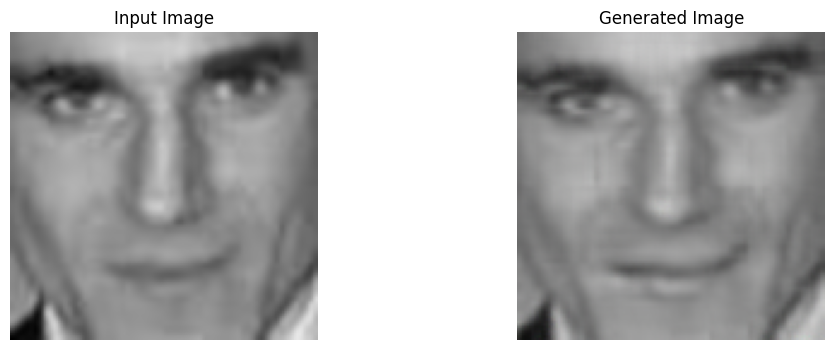

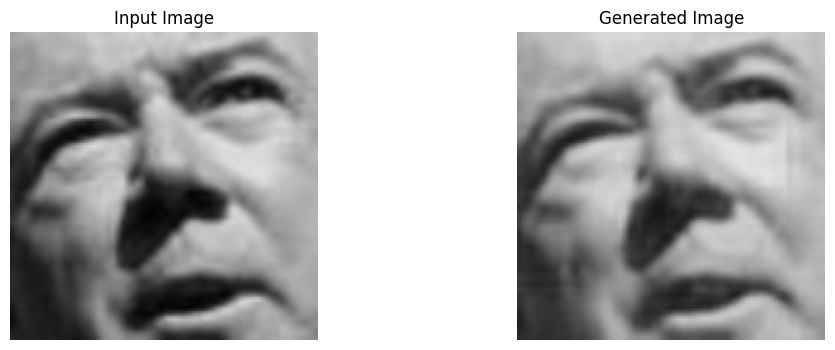

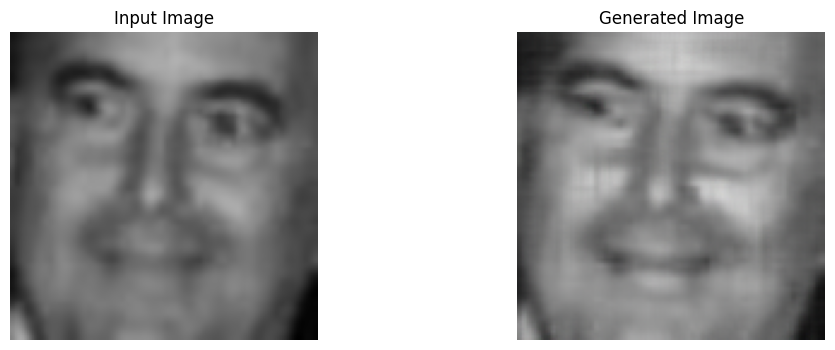

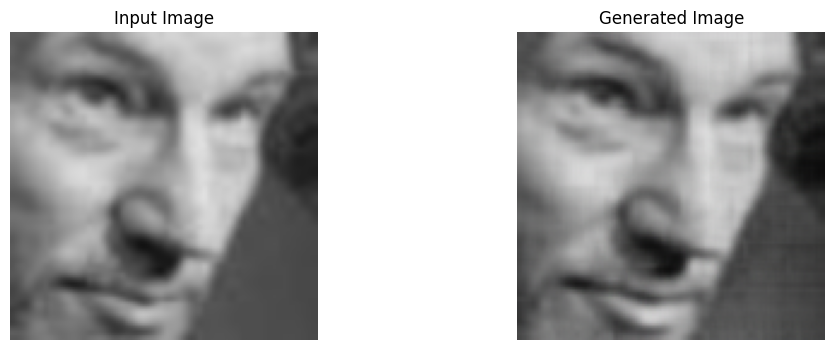

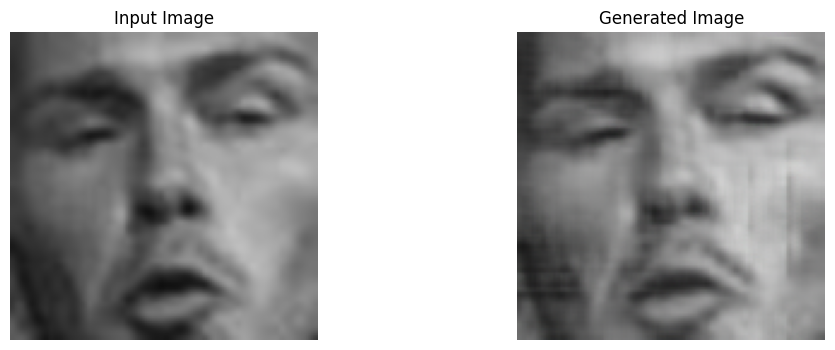

In [49]:
########################################
# Test the Trained Model with a Few Samples
########################################

def generate_images(test_input):
    """
    Generates a smiling image from the non-smiling input using gen_G,
    then displays them side by side.
    """
    # Expand dims to create a batch of size 1, then generate
    prediction = gen_G(tf.expand_dims(test_input, 0))[0]

    plt.figure(figsize=(12, 4))

    display_list = [test_input, prediction]
    titles = ['Input Image', 'Generated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        # Denormalize from [-1, 1] to [0, 1]
        img = (display_list[i] * 0.5 + 0.5).numpy()
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Test on a few images from your non_smiling_ds
for test_image_batch in non_smiling_ds.take(5):
    # test_image_batch is a batch of images; select the first image in the batch
    generate_images(test_image_batch[0])


# Thoughts on New Model 2

Qualitative inspection suggests that New Model 2 outperforms even New Model 1, primarily because the higher resolution and deeper ResNet generator minimize blur and produce more pronounced, detailed smiles. Smile lines look more defined, and the model is less prone to random pixel noise that plagued simpler architectures. Many images appear close to photorealistic, with fewer artifacts around the mouth and chin area.

Perhaps the greatest strength of New Model 2 is that it consistently preserves facial structure across different subject types, indicating a stronger generalization. Even in edge cases—such as profiles with partially obscured mouths or unusual lighting—it demonstrates fewer geometric distortions than the earlier models. Overall, this version sets a strong foundation for future expansions, such as integrating advanced attention mechanisms or style-based layers, to further refine the realism of generated smiles.

# Section 8: References

- Baeldung. Baeldung on Computer Science, 7 Apr. 2023, www.baeldung.com/cs/jpeg-compression.

- Balajisrinivas. “GitHub - Balajisrinivas/Smile-Detector-Using-Python.” GitHub, 2021, github.com/balajisrinivas/Smile-Detector-using-Python.

- Bishop, Christopher M. Pattern Recognition and Machine Learning. Link.springer.com, Springer, 2006, link.springer.com/book/9780387310732.

- Bottou, Léon. “Large-Scale Machine Learning with Stochastic Gradient Descent.” Proceedings of COMPSTAT’2010, 2010, pp. 177–186, https://doi.org/10.1007/978-3-7908-2604-3_16.

- Bradski, Gary, and Adrian Kaehler. “Learning OpenCV.” Www.oreilly.com, 1 Sept. 2008, www.oreilly.com/library/view/learning-opencv/9780596516130/.

- Cyme. “The Smile in Pictures: The Kingdom of Narcissus | CYME.” Stay on Top of Your Photos, 12 July 2022, cyme.io/the-smile-in-pictures-the-kingdom-of-narcisse/. Accessed 21 Oct. 2024.

- Godoy, Daniel. “Understanding Binary Cross-Entropy / Log Loss: A Visual Explanation.” Towards Data Science, Towards Data Science, 21 Nov. 2018, towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a.

- Goodfellow, Ian, et al. “Deep Learning.” MIT Press, 18 Nov. 2016, mitpress.mit.edu/9780262035613/deep-learning/.

- Hastie, Trevor, et al. The Elements of Statistical Learning. Springer Series in Statistics, New York, NY, Springer New York, 2009, link.springer.com/book/10.1007/978-0-387-84858-7.

- Kingma, Diederik P, and Jimmy Ba. “Adam: A Method for Stochastic Optimization.” ArXiv.org, 22 Dec. 2014, arxiv.org/abs/1412.6980.

- Mittal, Aditya. “Haar Cascades, Explained.” Medium, 21 Dec. 2020, medium.com/analytics-vidhya/haar-cascades-explained-38210e57970d.

- Ng, Andrew Y. “Feature Selection, L1 vs. L2 Regularization, and Rotational Invariance.” Twenty-First International Conference on Machine Learning - ICML ’04, 2004, core.ac.uk/display/24607301, https://doi.org/10.1145/1015330.1015435.

- Noble, Jake. “Array Type Features in Operational Machine Learning | Tecton.” Tecton, 8 Nov. 2021, www.tecton.ai/blog/introducing-array-type-features/. Accessed 21 Oct. 2024.

- Piasini, Eugenio, et al. How Occam’s Razor Guides Human Decision-Making. 10 Jan. 2023, https://doi.org/10.1101/2023.01.10.523479. Accessed 12 Feb. 2023.

- Rosebrock, Adrian. “Convolutional Neural Networks (CNNs) and Layer Types.” PyImageSearch, 14 May 2021, pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/.

- Yip, Andrew W, and Pawan Sinha. “Contribution of Color to Face Recognition.” Perception, vol. 31, no. 8, Aug. 2002, pp. 995–1003, web.mit.edu/sinhalab/Papers/yip_sinha_ColorFaces.pdf, https://doi.org/10.1068/p3376.